# Getting started with OpenAI gym
 
The OpenAI gym environment is one of the most fun ways to get into machine learning. Especially reinforcement learning and neural networks can be applied perfectly to the Atari games collection that is included. As every environment has multiple featured solutions, some with a writeup on how to achieve the same score, you can really improve yourself quickly in a fun way. 
 
I noticed that getting started with Gym can be a bit difficult. Although there are many tutorials for algorithms online, the first step is understanding the programming environment in which you are working. To easy new people into this environment I decided to make a small tutorial with a docker container and a jupyter notebook. 
 
### What you need
Before you get started, install Docker: https://docs.docker.com/engine/installation/#supported-platforms . Docker is a tool that lets you run virtual machines on your computer. I created an "image" that contains several things you want to have: tensorflow, the gym environment, numpy, and some other useful tools. 

After you installed Docker, run the following command to download my prepared docker image: 

```
docker run -p 8888:8888 -v rmeertens/tensorflowgym
```
 
 
In your browser, navigate to: localhost:8888 and open the OpenAI Universe notebook in the tradr folder.  
 
### Play a game yourself
Let's start by playing the cartpole game ourselves. You control a bar that has a pole on it. The goal of the "game" is to keep the bar upright as long as possible. There are two actions you can perform in this game: give a force to the left, or give a force to the right. To play this game manually, execute the first part of the code. 

By clicking left and right you apply a force, and you see the new state. Note that I programmed the game to automatically reset when you "lost" the game. 


In [1]:
%matplotlib notebook
from time import gmtime, strftime

import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display

import gym
from gym import wrappers


from matplotlib import animation
from JSAnimation.IPython_display import display_animation



def leftclicked(something):
    """ Apply a force to the left of the cart"""
    onclick(0)

def rightclicked(something):
    """ Apply a force to the right of the cart"""
    onclick(1)
    
def display_buttons():
    """ Display the buttons you can use to apply a force to the cart """
    left = widgets.Button(description="<")
    right = widgets.Button(description=">")
    display(left, right)
    
    left.on_click(leftclicked)
    right.on_click(rightclicked)

# Create the environment and display the initial state
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, '/tmp/cartpole-experiment-1')

observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
fig,ax = plt.subplots()
im = ax.imshow(firstframe) 

# Show the buttons to control the cart
display_buttons()


# Function that defines what happens when you click one of the buttons
frames = []
def onclick(action):
    global frames
    observation, reward, done, info = env.step(action)
    print(reward)
    frame = env.render(mode = 'rgb_array')
    im.set_data(frame)
    frames.append(frame)
    if done:
        print(env.reset())

    

[2017-06-27 13:56:54,781] Making new env: CartPole-v0
[2017-06-27 13:56:54,797] Creating monitor directory /tmp/cartpole-experiment-1
[2017-06-27 13:56:54,800] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video000000.mp4


<IPython.core.display.Javascript object>

### Replay 
Now that you toyed around you probably want to see a replay. Every button click we saved the state of the game, which you can display in your browser: 


In [2]:
def display_frames_as_gif(frames):
    if len(frames) == 0:
        return
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save('animation.gif', writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))

display_frames_as_gif(frames)


### Representation
The cardboard environment is described on the [OpenAI website](https://gym.openai.com/envs/CartPole-v0). The values in the observation parameter show the position of the cart and the angle of the pole. If the pole has an angle of more than 15 degrees, or the cart moves more than 2.4 units from the center, the game is "over". The environment can then be reset by calling env.reset(). 

### Start learning
This blogpost would be incomplete without a simple "learning" mechanism. Kevin Frans made a great blogpost about simple algorithms you can apply on this problem: http://kvfrans.com/simple-algoritms-for-solving-cartpole/. 

The simplest one to implement is his random search algorithm. By multiplying parameters with the observation parameters the cart either decides to apply the force left or right. Now the question is: what are the best parameters? Random search defines them at random, sees how long the cart lasts with those parameters, and remembers the best parameters it found. 


In [3]:
FRAMES_TO_CONSIDER = 4
ACTIONCOUNT = 2

In [4]:
import tensorflow as tf

inputstate = tf.placeholder(tf.float32, [None, FRAMES_TO_CONSIDER * 4], name='inputstate')
rewardplaceholder = tf.placeholder(tf.float32, [None], name='rewardplaceholder')
actionplaceholder = tf.placeholder(tf.float32, [None, ACTIONCOUNT], name='actionplaceholder')

linear1 = tf.contrib.layers.fully_connected(inputstate, 8)
output = tf.contrib.layers.fully_connected(linear1, ACTIONCOUNT, activation_fn = None)
qreward = tf.reduce_sum(tf.multiply(output, actionplaceholder), reduction_indices = 1)
loss = tf.reduce_mean(tf.square(rewardplaceholder - qreward))
optimizer = tf.train.RMSPropOptimizer(0.001).minimize(loss)



In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


In [6]:
import random
def get_random_hist(history, ncount):
    images = []
    values = []
    actions = []
    for _ in range(ncount):
        image, action, reward = random.choice(history)
        actionlist = [0]*ACTIONCOUNT
        actionlist[action]=1
        actions.append(actionlist)
        images.append(image)
        values.append(reward)
    return images, actions, values

In [7]:
state_rewards = [] # (state, action, discountedreward)
lastframes = []
for _ in range(FRAMES_TO_CONSIDER):
    action = env.action_space.sample() 
    observation, reward, done, info = env.step(action)
    lastframes.append(observation)
    if done:
        env.reset()
        
assert len(lastframes) == FRAMES_TO_CONSIDER
def frames_to_nd_image(frames):
    return np.reshape(np.array(frames), (-1))
state_rewards.append((frames_to_nd_image(lastframes), 0, reward))

images, actions, values = get_random_hist(state_rewards, 1)
expected = max(max(sess.run(output, feed_dict={inputstate:images})))
state_rewards[0] = (state_rewards[0][0], state_rewards[0][1], expected)

print(state_rewards)


[(array([-0.02335994, -0.17493695, -0.04959052,  0.27352655, -0.02685868,
        0.02085621, -0.04411999, -0.03437579, -0.02644156,  0.21658218,
       -0.0448075 , -0.3406461 , -0.02210991,  0.02212545, -0.05162042,
       -0.06242277]), 0, -0.049234882)]


In [8]:

_, l = sess.run([optimizer, loss], feed_dict={inputstate:images, rewardplaceholder: values, actionplaceholder: actions})
        

In [9]:
avg_rewards = []
avg_estimated = []

In [10]:
n_epochs = 200000
batch_size = 32
epsilon = 1.00
REPLAY_MEMORY_LENGTH = 1500 # use a replay memory of one million most recent frames
REPLAY_MEMORY_STRETCH = 50
EPOCH_SIZE = 5000 #  One epoch corresponds to 50000 minibatch weight updates or roughly 30 minutes of training time.
EPOCH_COUNT = 100
gamma = 0.7

for epoch_i in range(EPOCH_COUNT):
    sumrewards = 0.0
    sumestimatedfuture = 0.0
    for _ in range(EPOCH_SIZE): 
        images, actions, values = get_random_hist(state_rewards, batch_size)

        _, l = sess.run([optimizer, loss], feed_dict={inputstate:images, rewardplaceholder: values, actionplaceholder: actions})
        
        newimage = frames_to_nd_image(lastframes)
        
        if random.random() <= epsilon:
            newaction = env.action_space.sample() 
        else:    
            actions = sess.run(output, feed_dict={inputstate:np.array([newimage], dtype=np.float32)})
            actions = actions[0]
            newaction = np.argmax(np.array(actions))

        epsilon -= 0.9 / 10000 # anneal in a 10.000 steps...
        if epsilon < 0.1:
            epsilon = 0.1
        newobservation, rewardhere, done, info = env.step(newaction)
        
        lastframes.append(newobservation)
        lastframes = lastframes[1:]

        newerimage = frames_to_nd_image(lastframes)
        estimatedfuturereward = max(max(sess.run(output, feed_dict={inputstate:np.array([newerimage])})))
        
        sumrewards += rewardhere
        sumestimatedfuture += estimatedfuturereward
        
        if done: 
            totalreward = rewardhere
        else:
            totalreward = rewardhere + gamma * estimatedfuturereward
            
        wanttoadd = (newimage, newaction, totalreward)
        state_rewards.append(wanttoadd)
        if len(state_rewards) > REPLAY_MEMORY_LENGTH + REPLAY_MEMORY_STRETCH: 
            state_rewards = state_rewards[REPLAY_MEMORY_LENGTH:]

        if done:
            observation = env.reset()
            lastframes.append(observation)
            lastframes = lastframes[1:]
    timeup = strftime("%Y-%m-%d %H:%M:%S", gmtime())
    avg_reward_epoch = sumrewards/EPOCH_SIZE
    avg_estimated_epoch = sumestimatedfuture/EPOCH_SIZE
    avg_rewards.append(avg_reward_epoch)
    avg_estimated.append(avg_estimated_epoch)
    print("%s: Epoch: %d, avg reward: %f, avg estimated: %f, estimated future: %f, loss: %f, trainmat: %d" % (timeup, epoch_i,avg_reward_epoch , avg_estimated_epoch , estimatedfuturereward, l, len(state_rewards)))
        

[2017-06-27 13:56:57,493] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video000001.mp4
[2017-06-27 13:56:57,799] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video000008.mp4
[2017-06-27 13:56:58,316] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video000027.mp4
[2017-06-27 13:56:59,159] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video000064.mp4
[2017-06-27 13:57:00,416] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video000125.mp4
[2017-06-27 13:57:02,103] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video000216.mp4


2017-06-27 13:57:02: Epoch: 0, avg reward: 1.000000, avg estimated: 2.585578, estimated future: 3.294154, loss: 0.169902, trainmat: 501
2017-06-27 13:57:06: Epoch: 1, avg reward: 1.000000, avg estimated: 3.208849, estimated future: 3.414086, loss: 0.001447, trainmat: 1001


[2017-06-27 13:57:06,996] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video000343.mp4


2017-06-27 13:57:12: Epoch: 2, avg reward: 1.000000, avg estimated: 3.300605, estimated future: 3.384197, loss: 0.003375, trainmat: 1501
2017-06-27 13:57:17: Epoch: 3, avg reward: 1.000000, avg estimated: 3.305042, estimated future: 3.144455, loss: 0.138516, trainmat: 501
2017-06-27 13:57:21: Epoch: 4, avg reward: 1.000000, avg estimated: 3.308455, estimated future: 3.299522, loss: 0.000831, trainmat: 1001


[2017-06-27 13:57:25,392] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video000512.mp4


2017-06-27 13:57:27: Epoch: 5, avg reward: 1.000000, avg estimated: 3.300144, estimated future: 3.259227, loss: 0.040335, trainmat: 1501
2017-06-27 13:57:32: Epoch: 6, avg reward: 1.000000, avg estimated: 3.221315, estimated future: 3.288867, loss: 0.078421, trainmat: 501
2017-06-27 13:57:36: Epoch: 7, avg reward: 1.000000, avg estimated: 3.295531, estimated future: 3.306059, loss: 0.002474, trainmat: 1001
2017-06-27 13:57:40: Epoch: 8, avg reward: 1.000000, avg estimated: 3.286830, estimated future: 3.372656, loss: 0.003459, trainmat: 1501


[2017-06-27 13:57:44,436] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video000729.mp4


2017-06-27 13:57:46: Epoch: 9, avg reward: 1.000000, avg estimated: 3.313587, estimated future: 3.324656, loss: 0.007113, trainmat: 501
2017-06-27 13:57:51: Epoch: 10, avg reward: 1.000000, avg estimated: 3.311027, estimated future: 3.204033, loss: 0.001706, trainmat: 1001
2017-06-27 13:57:55: Epoch: 11, avg reward: 1.000000, avg estimated: 3.307501, estimated future: 3.344378, loss: 0.001694, trainmat: 1501
2017-06-27 13:57:59: Epoch: 12, avg reward: 1.000000, avg estimated: 3.319986, estimated future: 3.372173, loss: 0.001255, trainmat: 501
2017-06-27 13:58:03: Epoch: 13, avg reward: 1.000000, avg estimated: 3.298631, estimated future: 3.286682, loss: 0.074283, trainmat: 1001
2017-06-27 13:58:07: Epoch: 14, avg reward: 1.000000, avg estimated: 3.280587, estimated future: 3.307431, loss: 0.005190, trainmat: 1501


[2017-06-27 13:58:08,652] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video001000.mp4


2017-06-27 13:58:14: Epoch: 15, avg reward: 1.000000, avg estimated: 3.296037, estimated future: 3.238440, loss: 0.002753, trainmat: 501
2017-06-27 13:58:19: Epoch: 16, avg reward: 1.000000, avg estimated: 3.255693, estimated future: 3.171263, loss: 0.012239, trainmat: 1001
2017-06-27 13:58:23: Epoch: 17, avg reward: 1.000000, avg estimated: 3.251466, estimated future: 3.097665, loss: 0.002805, trainmat: 1501
2017-06-27 13:58:27: Epoch: 18, avg reward: 1.000000, avg estimated: 3.270104, estimated future: 3.324451, loss: 0.002442, trainmat: 501
2017-06-27 13:58:31: Epoch: 19, avg reward: 1.000000, avg estimated: 3.305825, estimated future: 3.345485, loss: 0.001985, trainmat: 1001
2017-06-27 13:58:35: Epoch: 20, avg reward: 1.000000, avg estimated: 3.255531, estimated future: 3.365614, loss: 0.005909, trainmat: 1501
2017-06-27 13:58:39: Epoch: 21, avg reward: 1.000000, avg estimated: 3.319224, estimated future: 3.240183, loss: 0.002293, trainmat: 501
2017-06-27 13:58:44: Epoch: 22, avg r

[2017-06-27 13:59:16,133] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video002000.mp4


2017-06-27 13:59:18: Epoch: 30, avg reward: 1.000000, avg estimated: 3.267771, estimated future: 3.460502, loss: 0.009419, trainmat: 501
2017-06-27 13:59:23: Epoch: 31, avg reward: 1.000000, avg estimated: 3.329230, estimated future: 3.343125, loss: 0.000512, trainmat: 1001
2017-06-27 13:59:27: Epoch: 32, avg reward: 1.000000, avg estimated: 3.252400, estimated future: 3.309127, loss: 0.012484, trainmat: 1501
2017-06-27 13:59:31: Epoch: 33, avg reward: 1.000000, avg estimated: 3.267895, estimated future: 3.264237, loss: 0.031456, trainmat: 501
2017-06-27 13:59:35: Epoch: 34, avg reward: 1.000000, avg estimated: 3.287240, estimated future: 3.363514, loss: 0.019346, trainmat: 1001
2017-06-27 13:59:39: Epoch: 35, avg reward: 1.000000, avg estimated: 3.278387, estimated future: 3.273114, loss: 0.027355, trainmat: 1501
2017-06-27 13:59:43: Epoch: 36, avg reward: 1.000000, avg estimated: 3.202599, estimated future: 3.177045, loss: 0.008766, trainmat: 501
2017-06-27 13:59:47: Epoch: 37, avg r

[2017-06-27 14:00:17,625] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video003000.mp4


2017-06-27 14:00:22: Epoch: 45, avg reward: 1.000000, avg estimated: 3.271600, estimated future: 2.860187, loss: 0.009623, trainmat: 501
2017-06-27 14:00:26: Epoch: 46, avg reward: 1.000000, avg estimated: 3.259398, estimated future: 3.436009, loss: 0.006184, trainmat: 1001
2017-06-27 14:00:30: Epoch: 47, avg reward: 1.000000, avg estimated: 3.280985, estimated future: 3.136185, loss: 0.301790, trainmat: 1501
2017-06-27 14:00:35: Epoch: 48, avg reward: 1.000000, avg estimated: 3.248164, estimated future: 3.332868, loss: 0.122685, trainmat: 501
2017-06-27 14:00:39: Epoch: 49, avg reward: 1.000000, avg estimated: 3.286655, estimated future: 3.340115, loss: 0.001508, trainmat: 1001
2017-06-27 14:00:43: Epoch: 50, avg reward: 1.000000, avg estimated: 3.321559, estimated future: 3.366942, loss: 0.017657, trainmat: 1501
2017-06-27 14:00:47: Epoch: 51, avg reward: 1.000000, avg estimated: 3.113173, estimated future: 3.371136, loss: 0.005811, trainmat: 501
2017-06-27 14:00:51: Epoch: 52, avg r

[2017-06-27 14:01:17,769] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video004000.mp4


2017-06-27 14:01:21: Epoch: 59, avg reward: 1.000000, avg estimated: 3.225143, estimated future: 3.305036, loss: 0.002090, trainmat: 1501
2017-06-27 14:01:25: Epoch: 60, avg reward: 1.000000, avg estimated: 3.258468, estimated future: 3.161721, loss: 0.015777, trainmat: 501
2017-06-27 14:01:29: Epoch: 61, avg reward: 1.000000, avg estimated: 3.311034, estimated future: 3.326505, loss: 0.022144, trainmat: 1001
2017-06-27 14:01:33: Epoch: 62, avg reward: 1.000000, avg estimated: 3.194073, estimated future: 3.314454, loss: 0.000817, trainmat: 1501
2017-06-27 14:01:37: Epoch: 63, avg reward: 1.000000, avg estimated: 3.260955, estimated future: 3.324798, loss: 0.040387, trainmat: 501
2017-06-27 14:01:42: Epoch: 64, avg reward: 1.000000, avg estimated: 3.291244, estimated future: 3.190007, loss: 0.009779, trainmat: 1001
2017-06-27 14:01:46: Epoch: 65, avg reward: 1.000000, avg estimated: 3.199860, estimated future: 3.204335, loss: 0.029113, trainmat: 1501
2017-06-27 14:01:50: Epoch: 66, avg 

[2017-06-27 14:02:19,314] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video005000.mp4


2017-06-27 14:02:23: Epoch: 74, avg reward: 1.000000, avg estimated: 3.144138, estimated future: 3.424650, loss: 0.002255, trainmat: 1501
2017-06-27 14:02:27: Epoch: 75, avg reward: 1.000000, avg estimated: 3.254177, estimated future: 3.265111, loss: 0.008561, trainmat: 501
2017-06-27 14:02:31: Epoch: 76, avg reward: 1.000000, avg estimated: 3.229745, estimated future: 3.366092, loss: 0.001568, trainmat: 1001
2017-06-27 14:02:35: Epoch: 77, avg reward: 1.000000, avg estimated: 3.248718, estimated future: 3.301359, loss: 0.016483, trainmat: 1501
2017-06-27 14:02:39: Epoch: 78, avg reward: 1.000000, avg estimated: 3.220290, estimated future: 3.211442, loss: 0.153718, trainmat: 501
2017-06-27 14:02:43: Epoch: 79, avg reward: 1.000000, avg estimated: 3.267316, estimated future: 3.329427, loss: 0.004021, trainmat: 1001
2017-06-27 14:02:47: Epoch: 80, avg reward: 1.000000, avg estimated: 3.312230, estimated future: 3.225839, loss: 0.055702, trainmat: 1501
2017-06-27 14:02:51: Epoch: 81, avg 

[2017-06-27 14:02:59,515] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video006000.mp4


2017-06-27 14:03:01: Epoch: 83, avg reward: 1.000000, avg estimated: 3.135311, estimated future: 3.572078, loss: 0.016702, trainmat: 1501
2017-06-27 14:03:05: Epoch: 84, avg reward: 1.000000, avg estimated: 3.250970, estimated future: 3.259195, loss: 0.004436, trainmat: 501
2017-06-27 14:03:09: Epoch: 85, avg reward: 1.000000, avg estimated: 3.295231, estimated future: 3.350233, loss: 0.013831, trainmat: 1001
2017-06-27 14:03:13: Epoch: 86, avg reward: 1.000000, avg estimated: 3.208170, estimated future: 3.307617, loss: 0.009270, trainmat: 1501
2017-06-27 14:03:17: Epoch: 87, avg reward: 1.000000, avg estimated: 3.258569, estimated future: 3.332127, loss: 0.060798, trainmat: 501
2017-06-27 14:03:21: Epoch: 88, avg reward: 1.000000, avg estimated: 3.292484, estimated future: 3.204792, loss: 0.008565, trainmat: 1001
2017-06-27 14:03:25: Epoch: 89, avg reward: 1.000000, avg estimated: 3.268171, estimated future: 3.265438, loss: 0.007162, trainmat: 1501
2017-06-27 14:03:29: Epoch: 90, avg 

[2017-06-27 14:04:02,394] Starting new video recorder writing to /tmp/cartpole-experiment-1/openaigym.video.0.11597.video007000.mp4


2017-06-27 14:04:07: Epoch: 99, avg reward: 1.000000, avg estimated: 3.109930, estimated future: 3.342739, loss: 0.001389, trainmat: 501


In [13]:
env.close()
with open("openaigym_apikey.txt") as f:
    for line in f:
        api_key_read = line
gym.upload('/tmp/cartpole-experiment-1', api_key=api_key_read)


[2017-06-27 14:07:36,838] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/cartpole-experiment-1')
[2017-06-27 14:07:38,251] [CartPole-v0] Uploading 7109 episodes of training data
[2017-06-27 14:07:41,513] [CartPole-v0] Uploading videos of 17 training episodes (87548 bytes)
[2017-06-27 14:07:42,440] [CartPole-v0] Creating evaluation object from /tmp/cartpole-experiment-1 with learning curve and training video
[2017-06-27 14:07:43,024] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_gtcJa9LDQACMaOd07U1Kbw

****************************************************


<IPython.core.display.Javascript object>


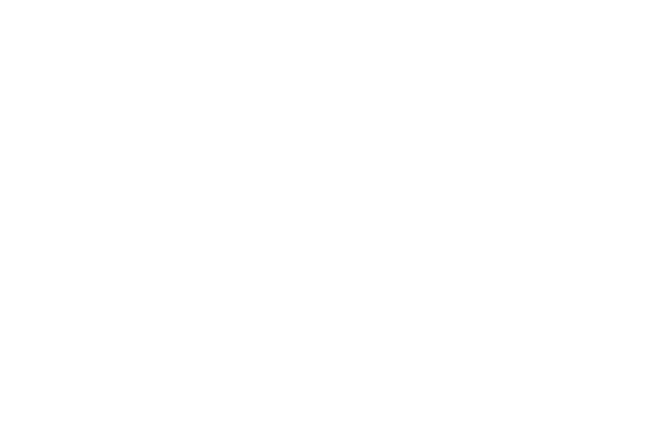


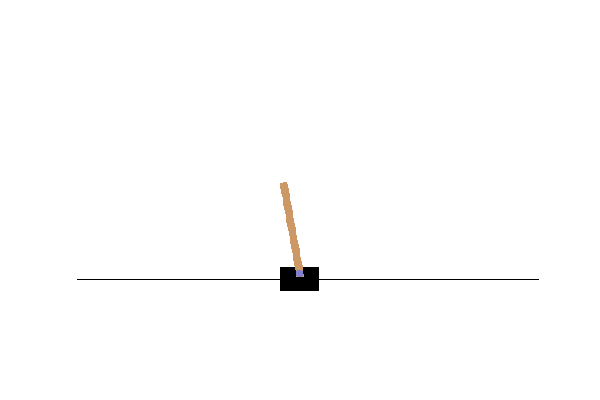
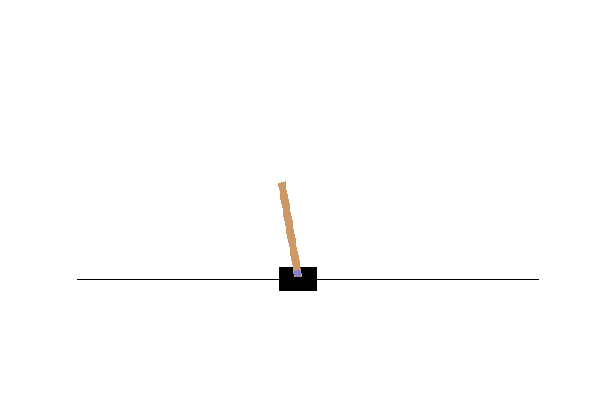
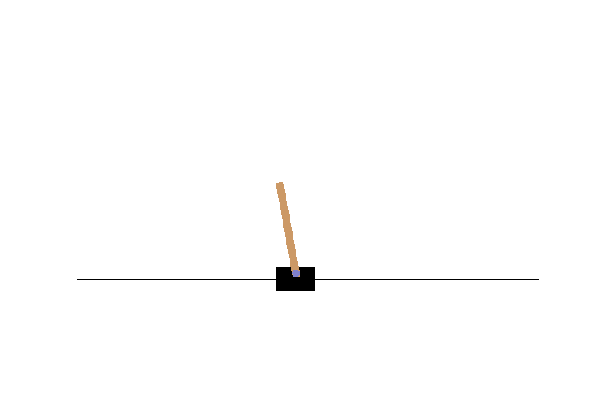
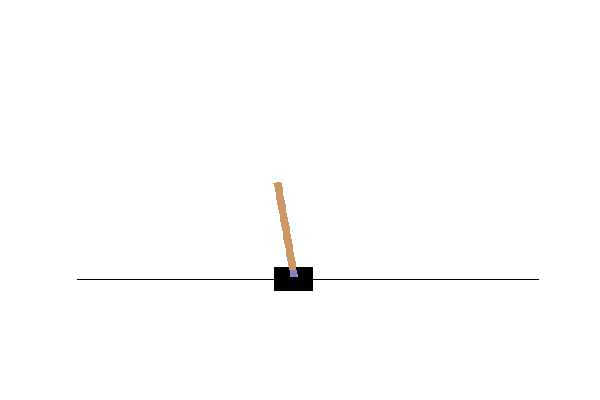
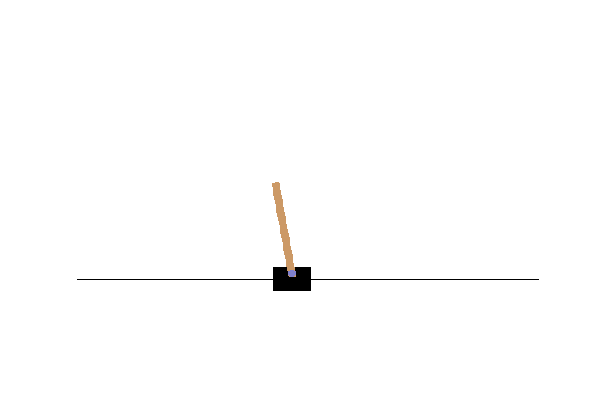
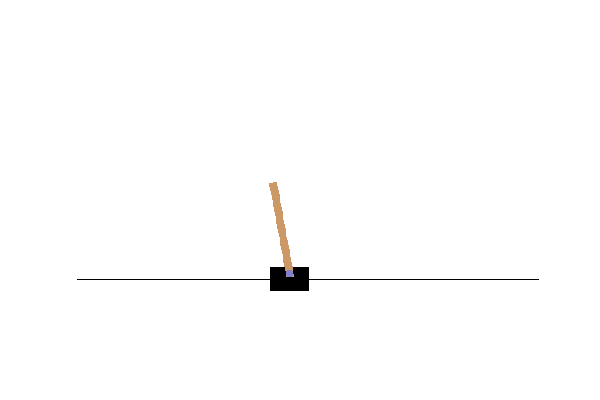
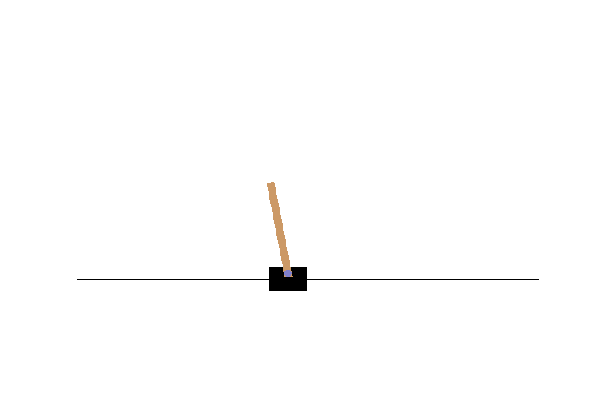
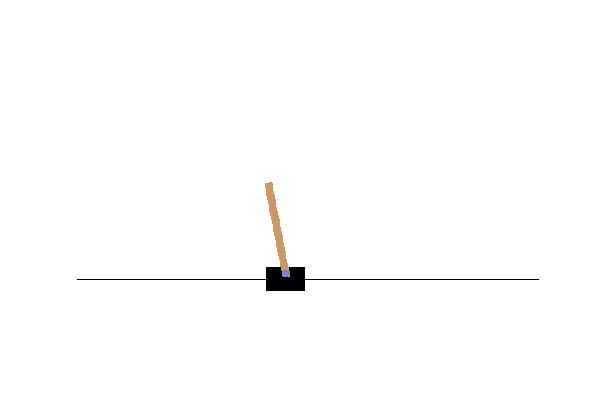
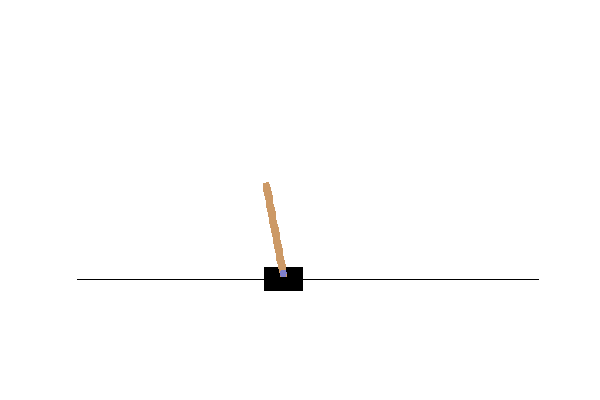
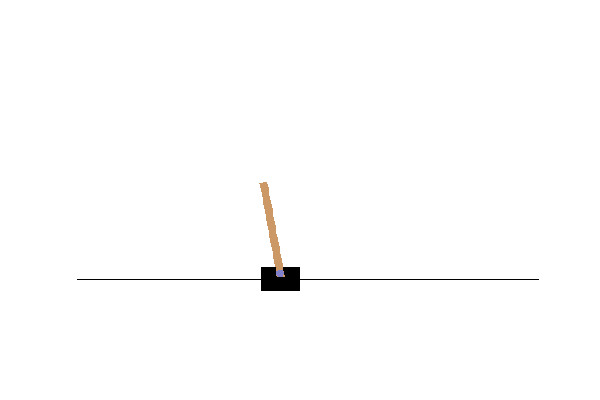
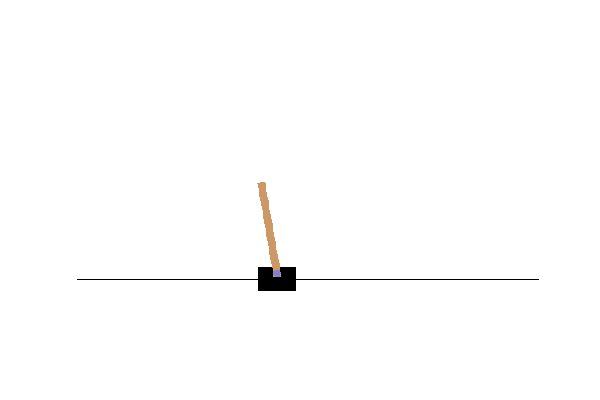
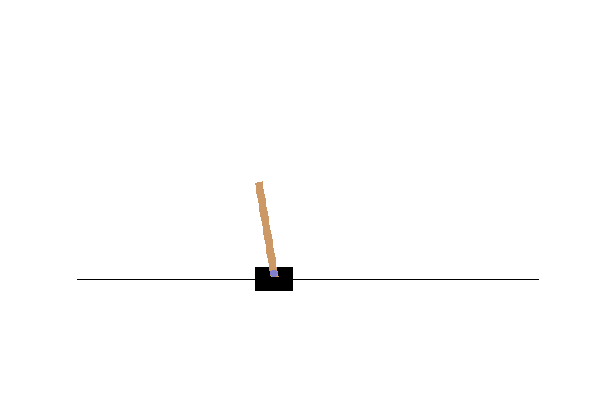
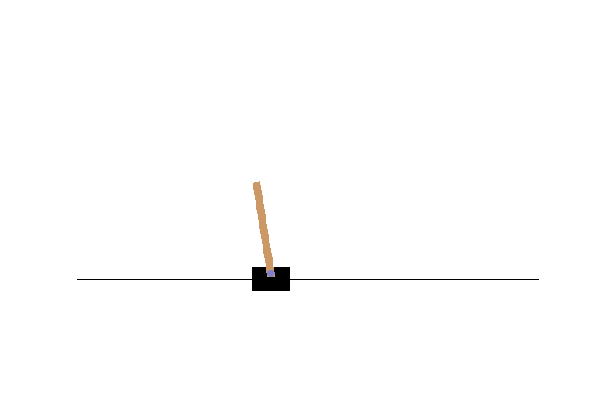
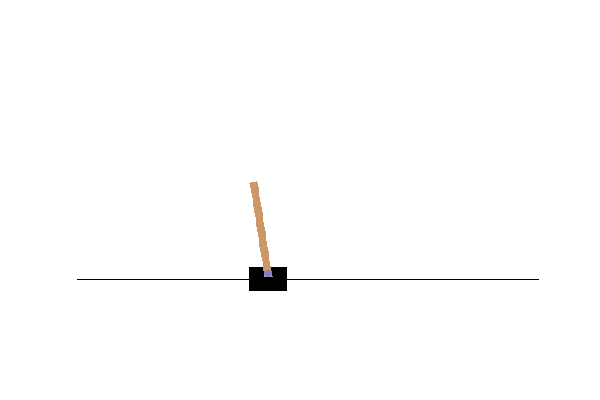
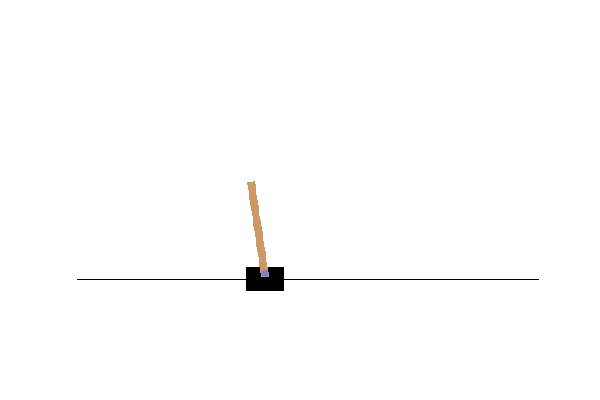
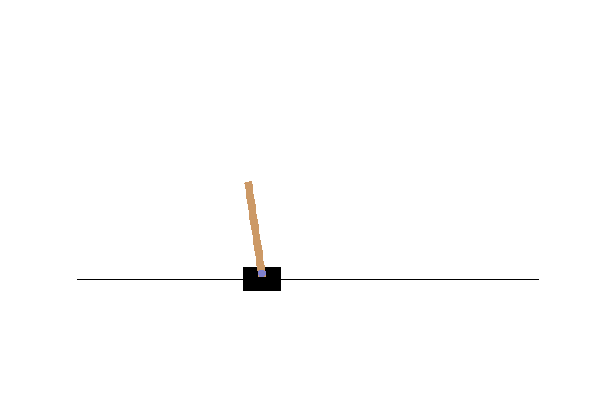
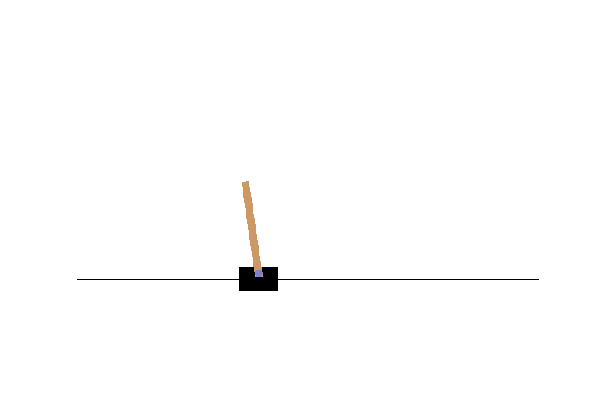
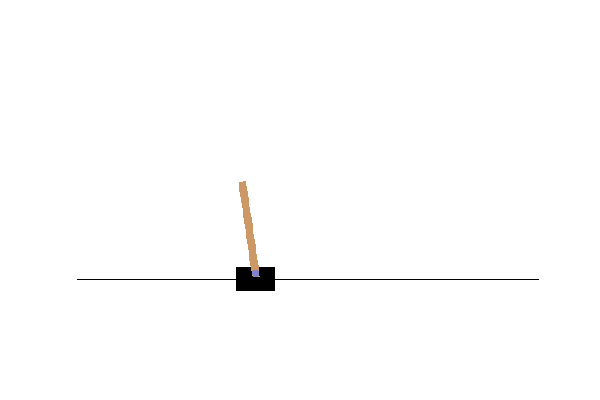
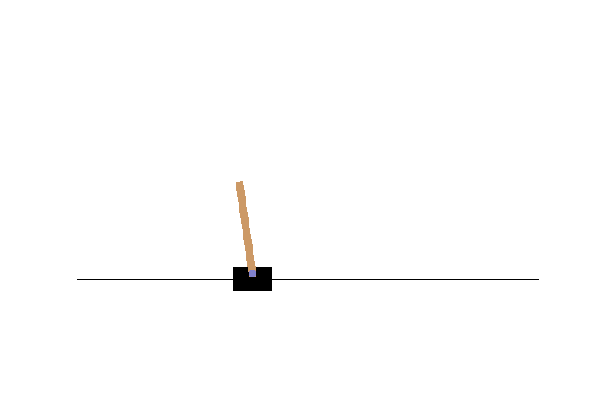
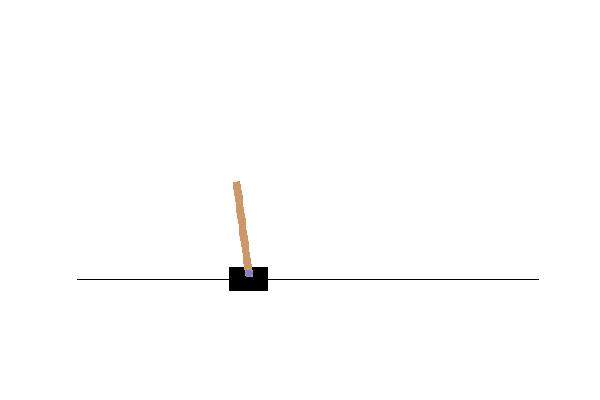
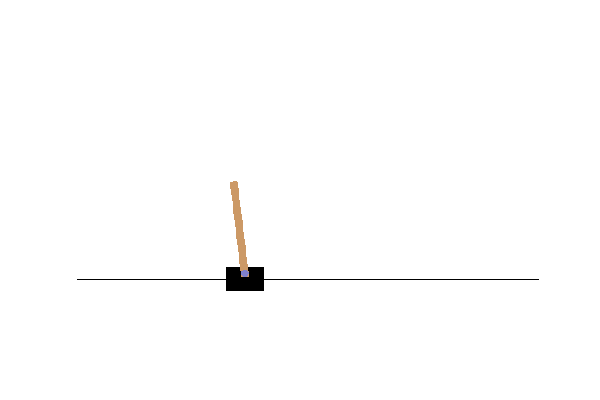
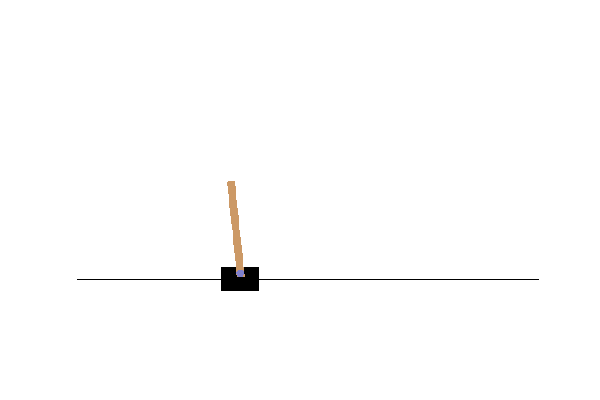
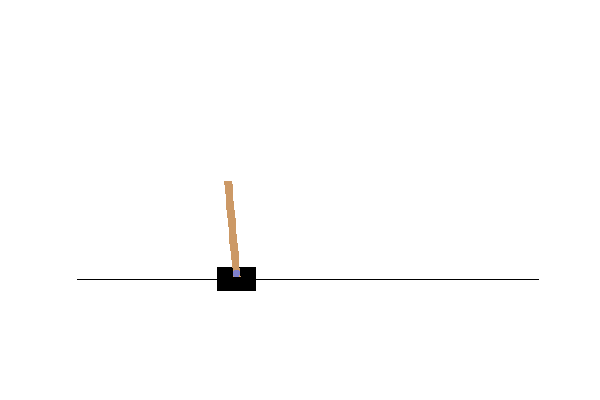
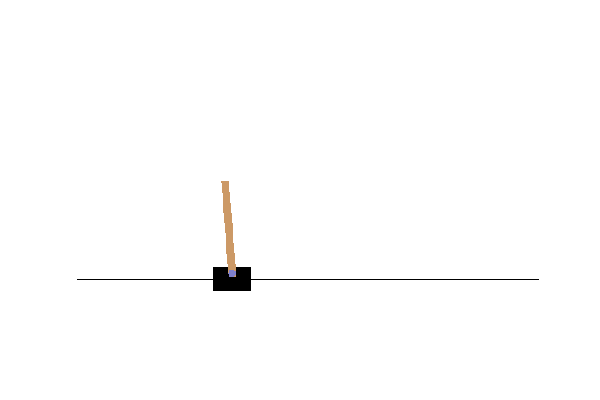
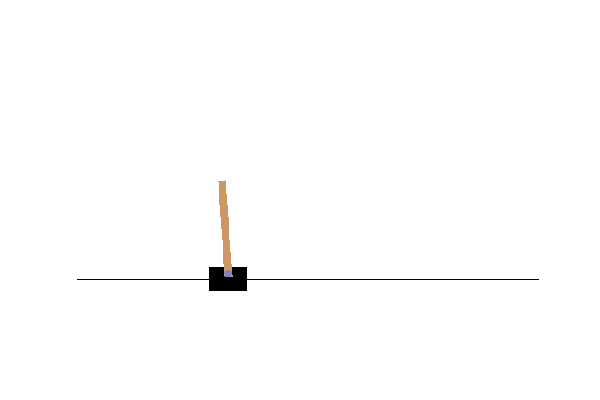
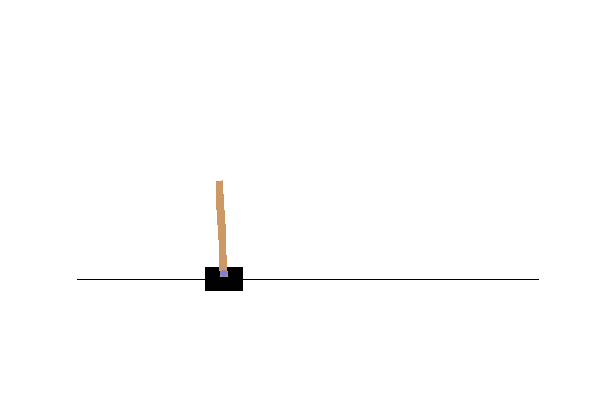
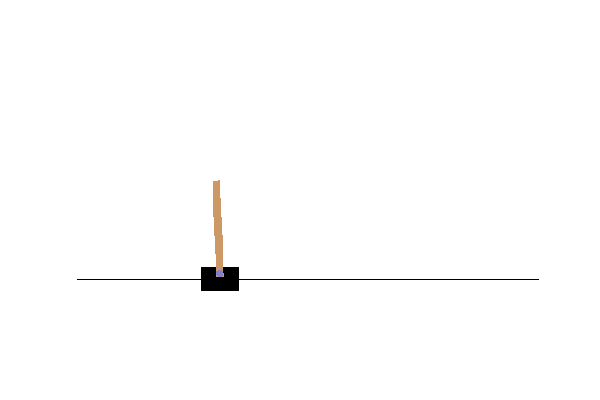
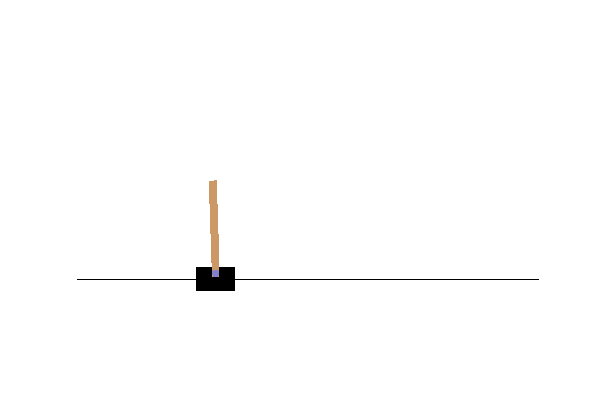
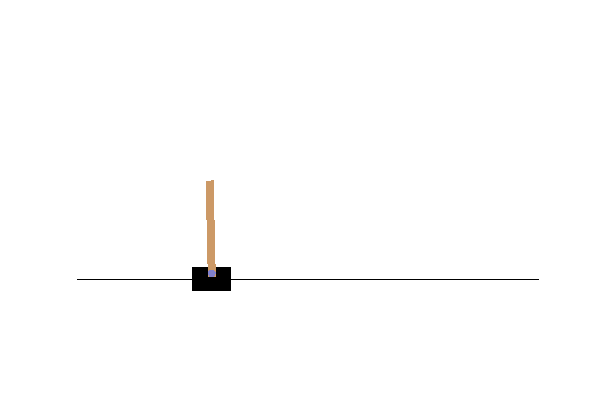
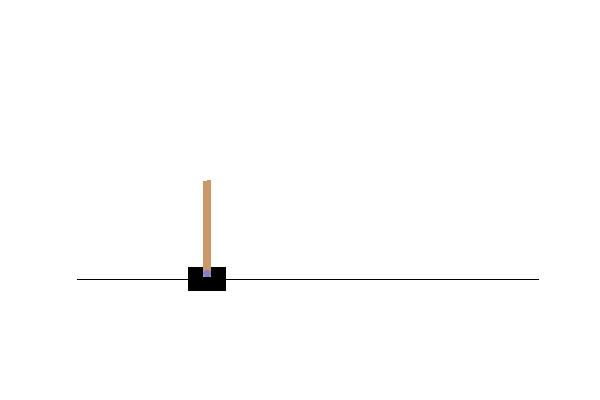
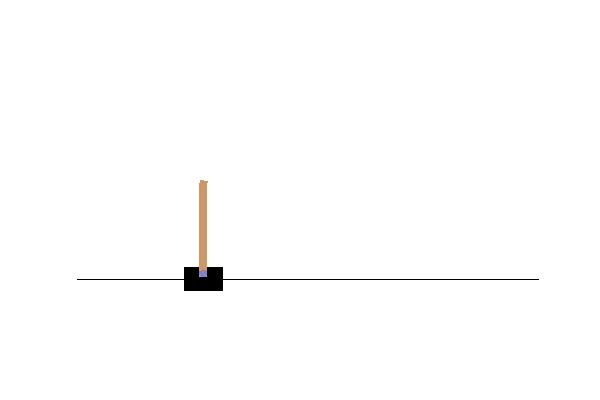
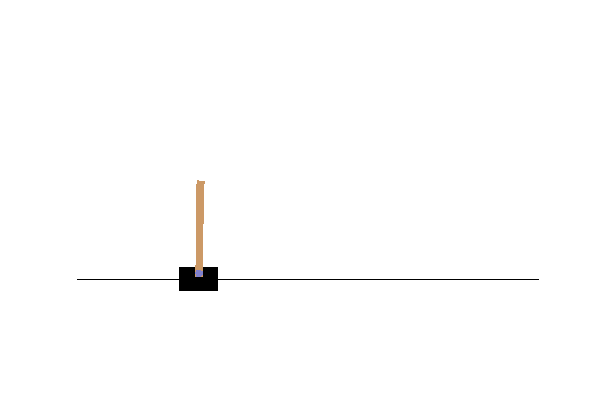
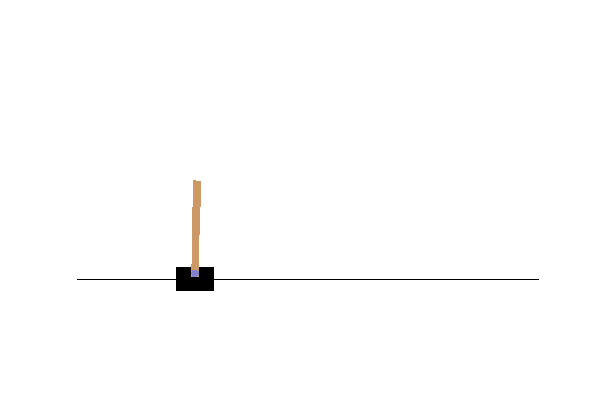
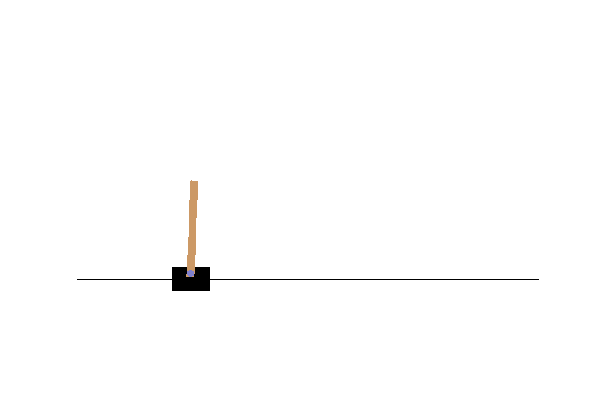
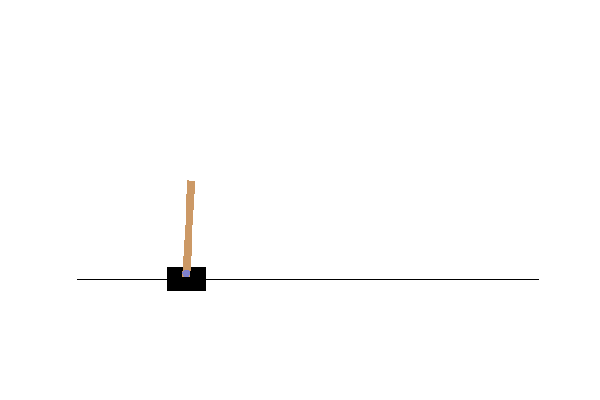
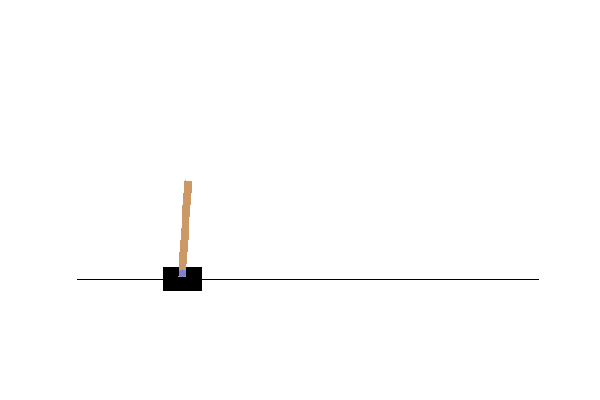
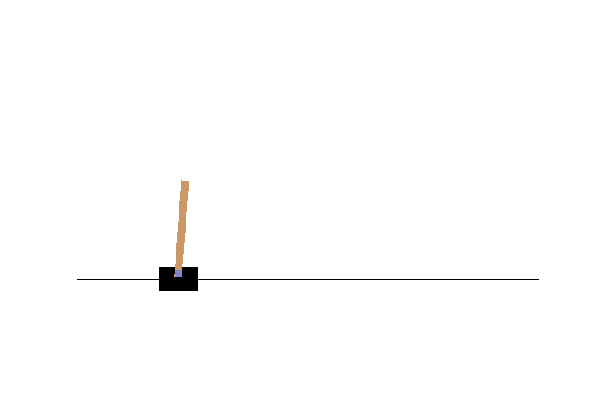
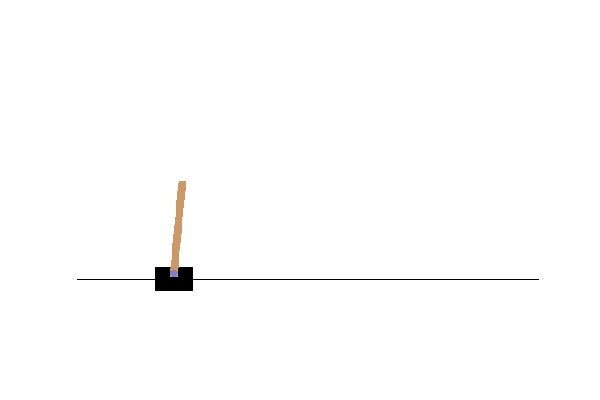
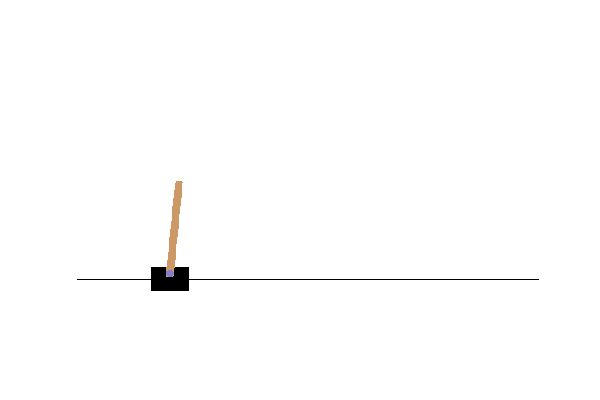
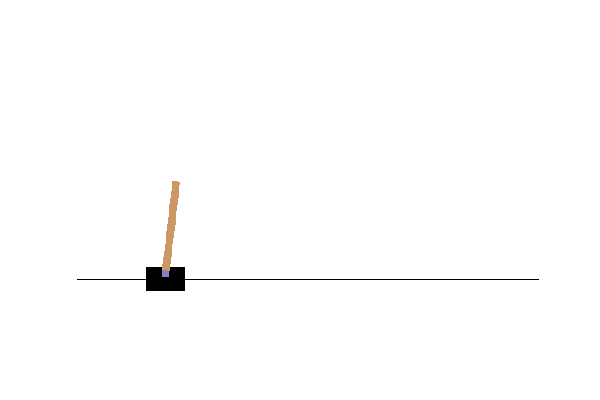
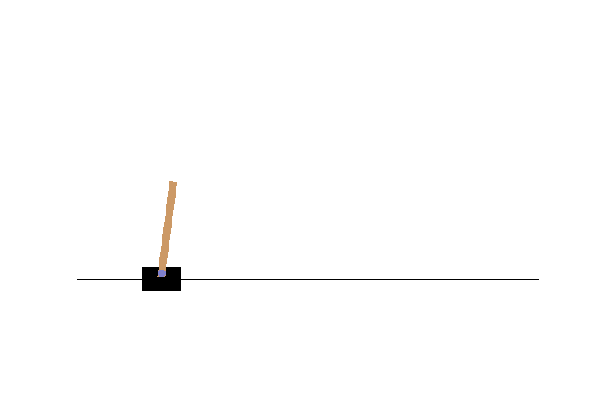
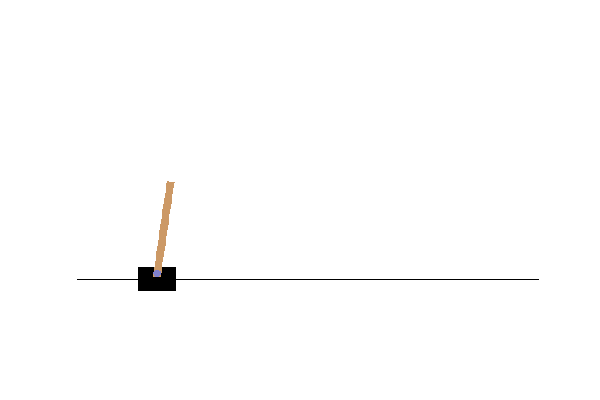
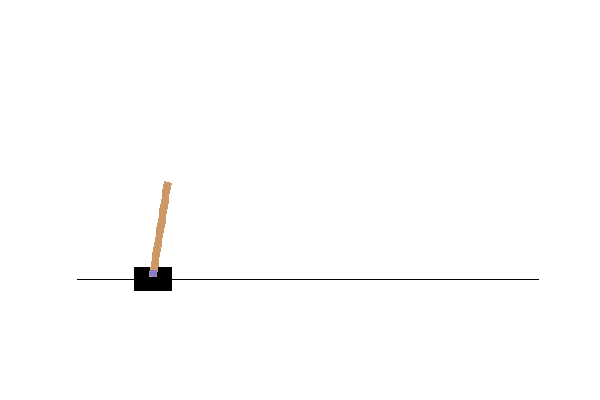
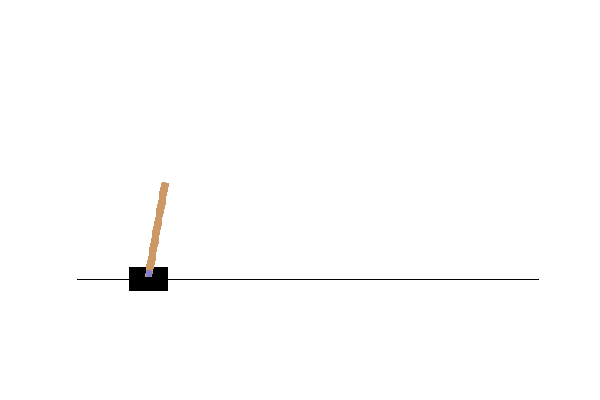
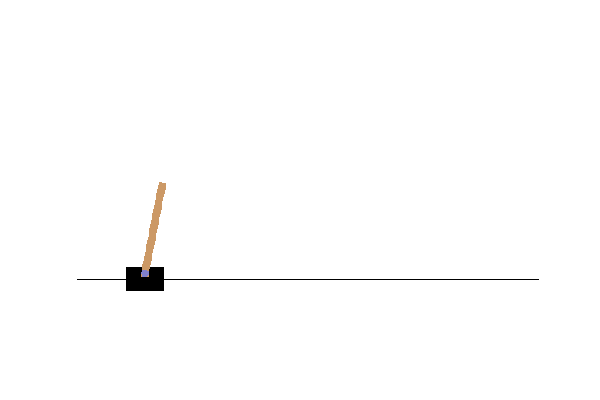
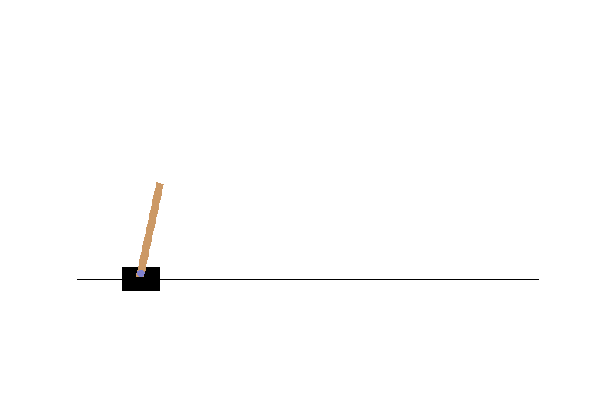
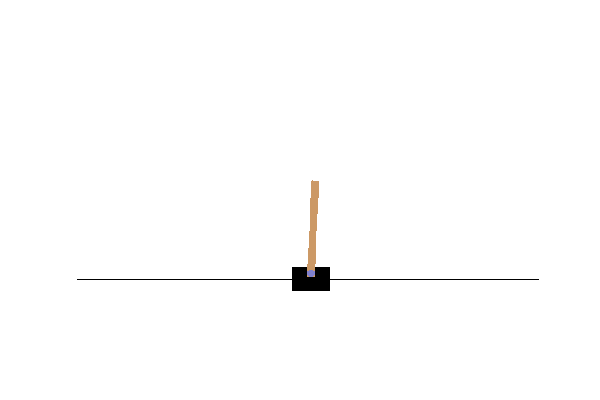
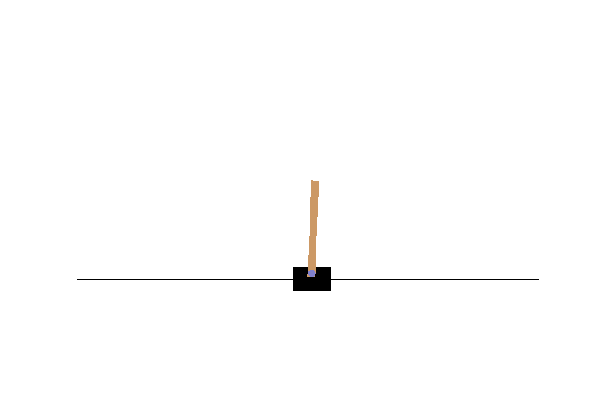
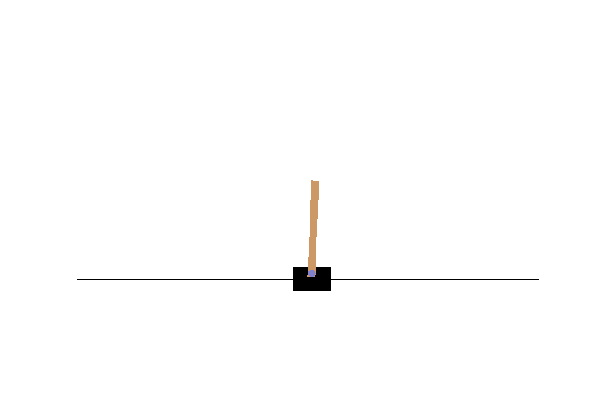
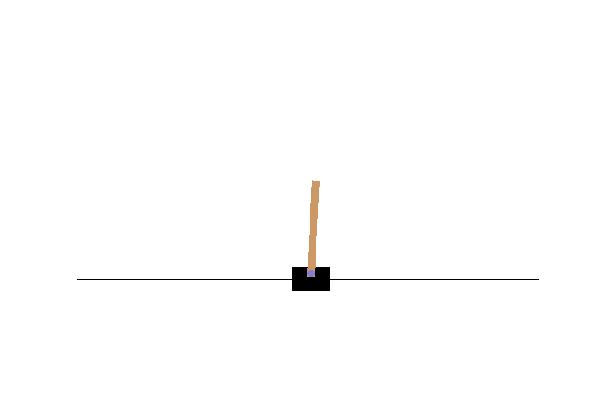
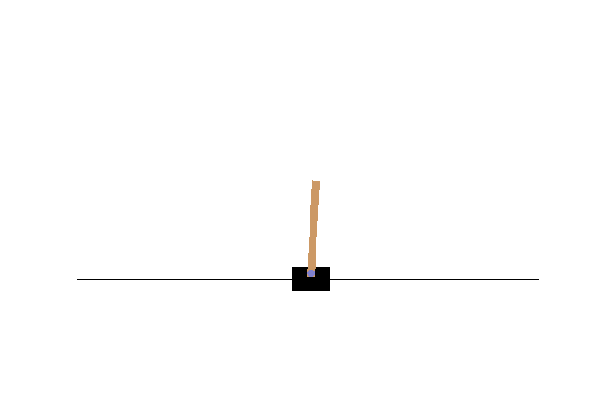
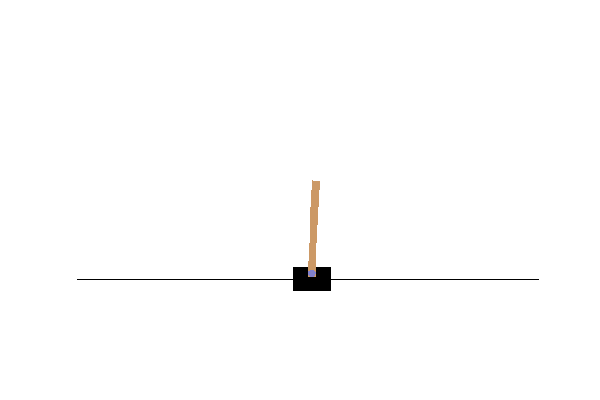
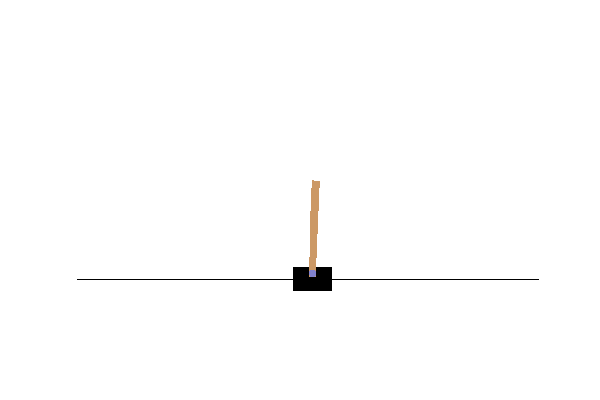
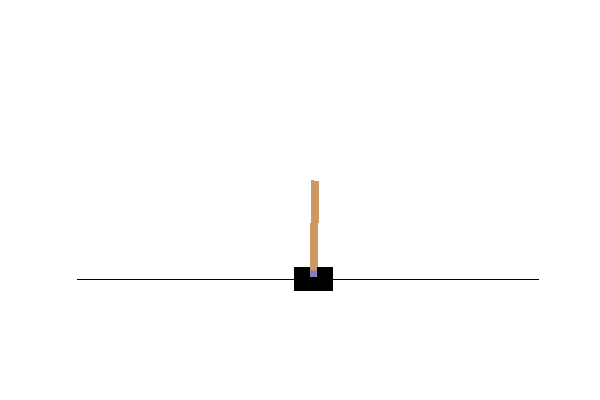
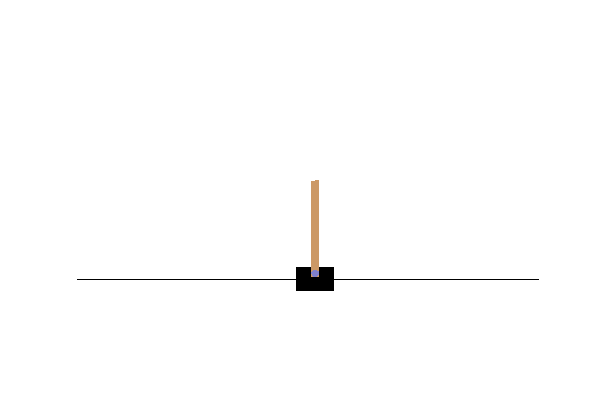
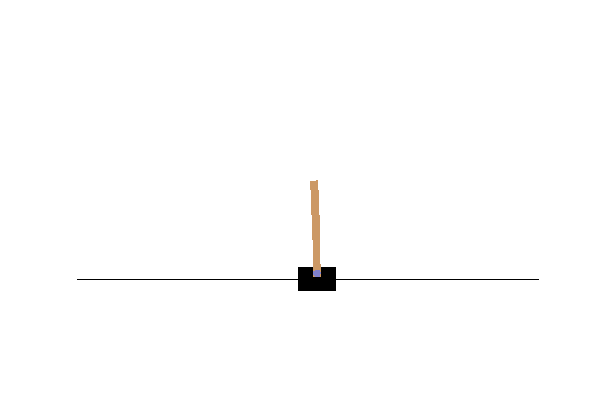
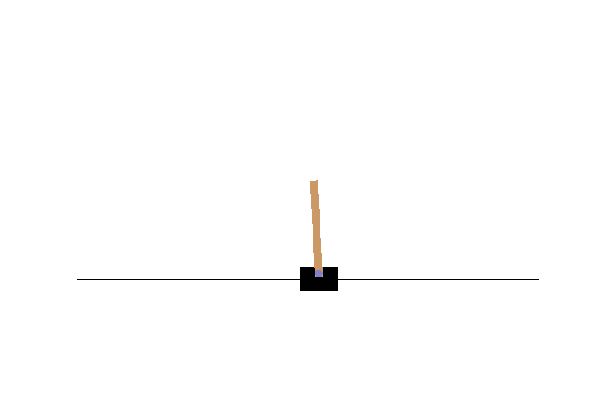
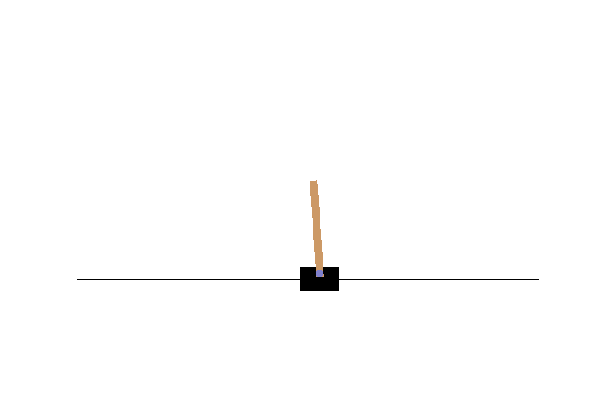
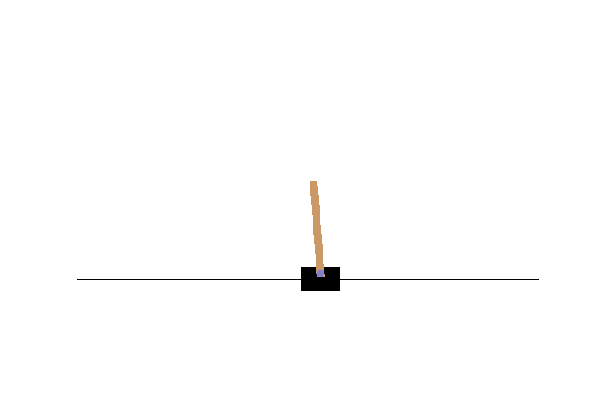
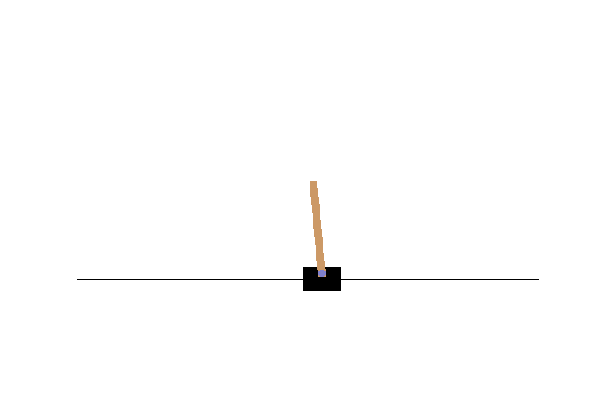
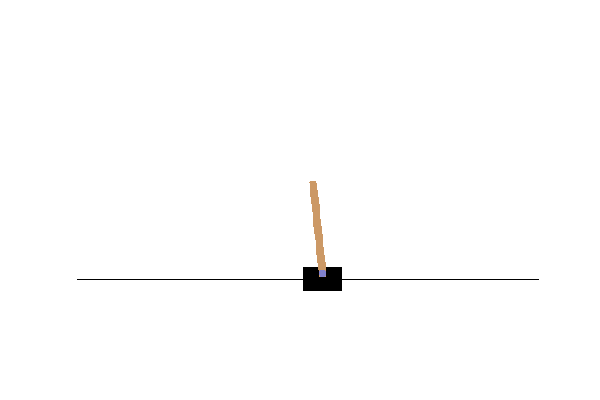
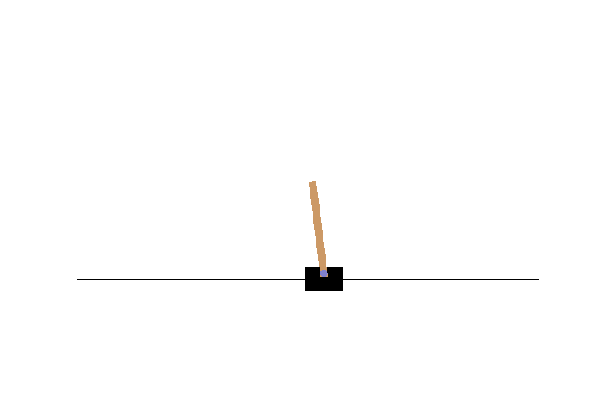
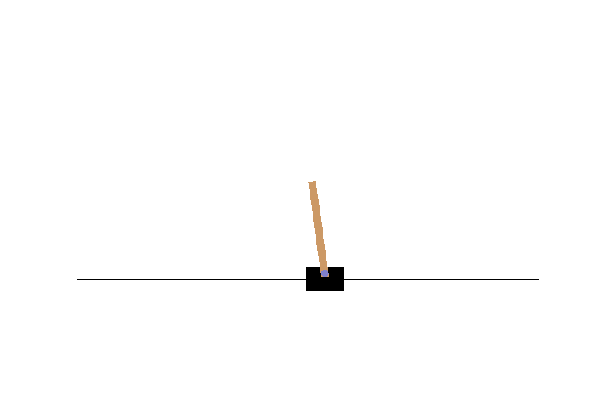
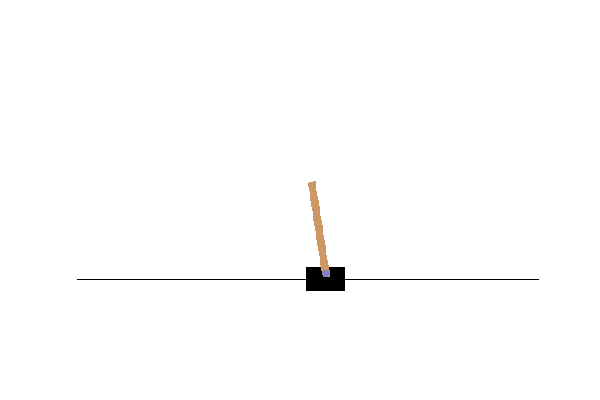
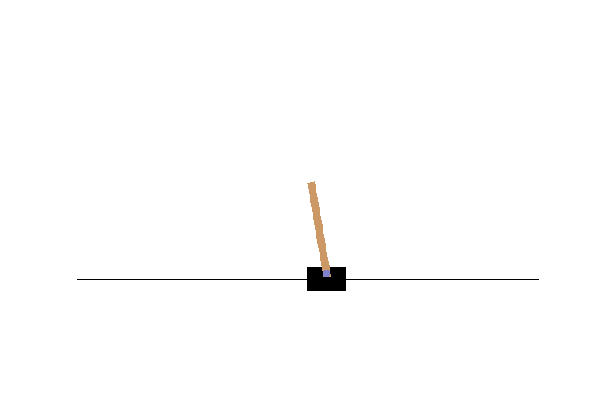
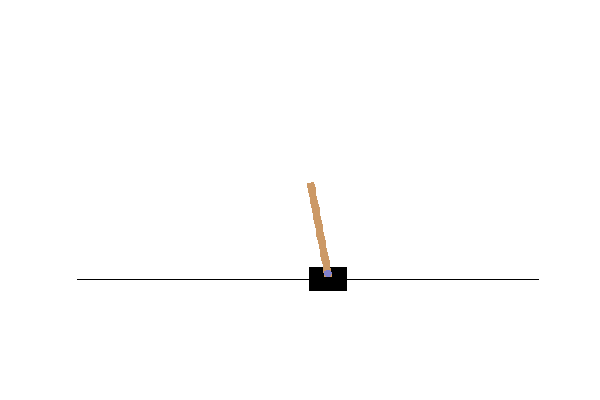
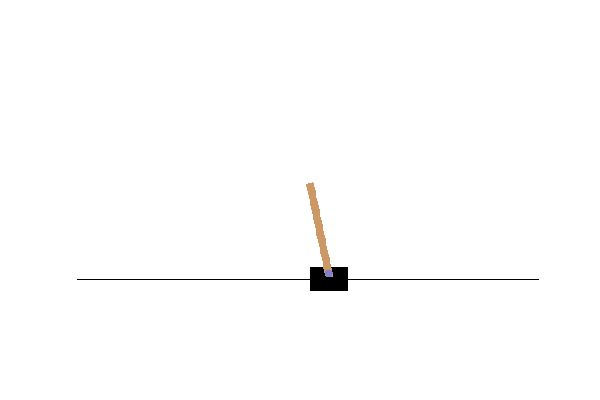
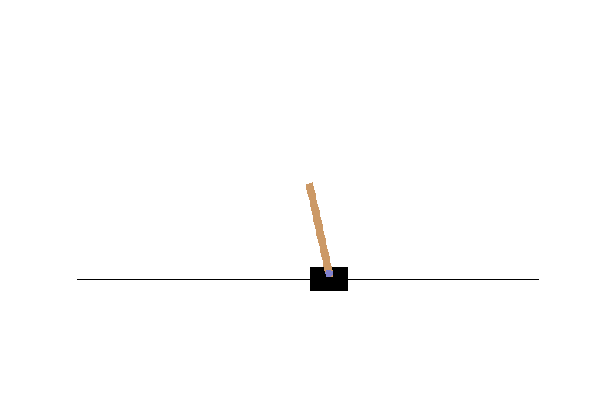
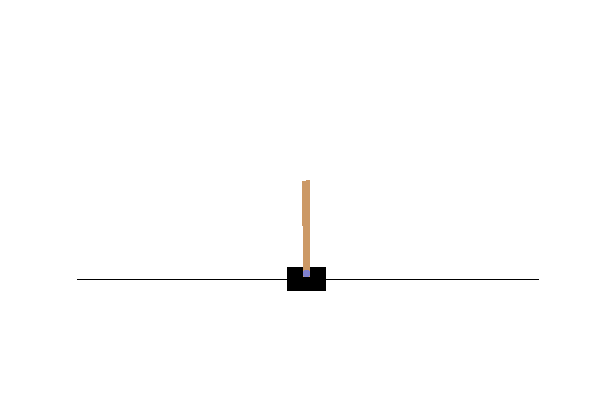
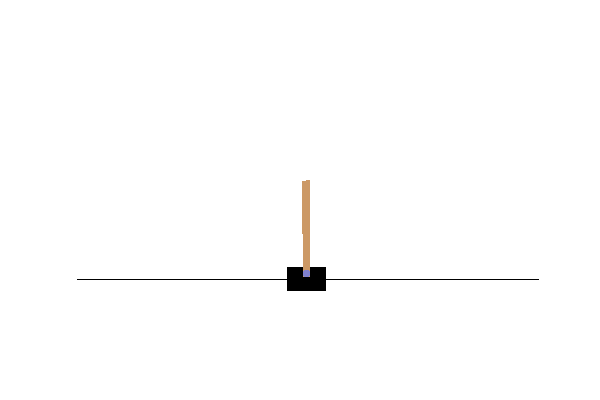
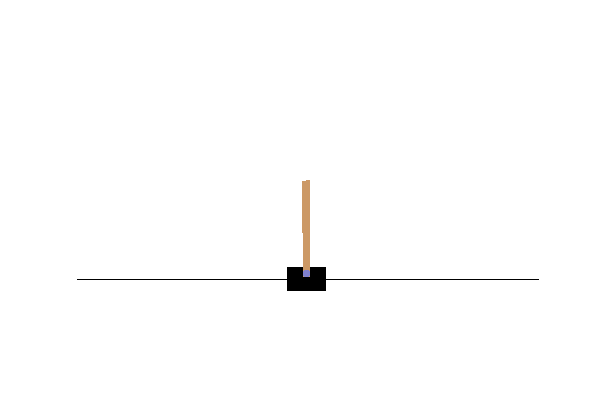
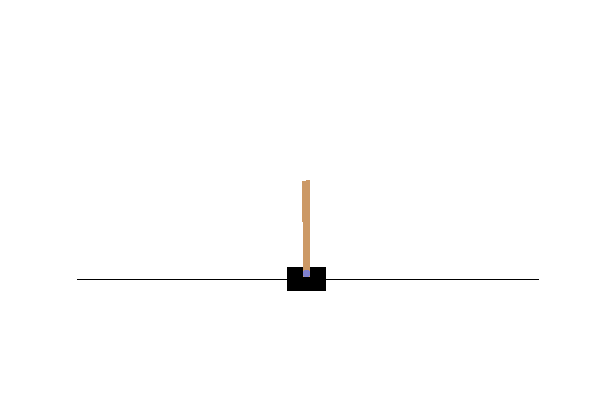
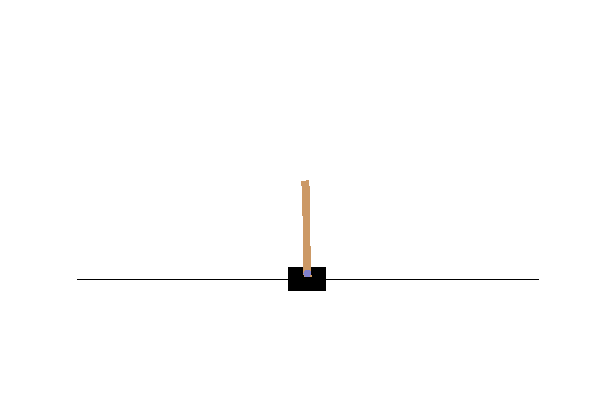
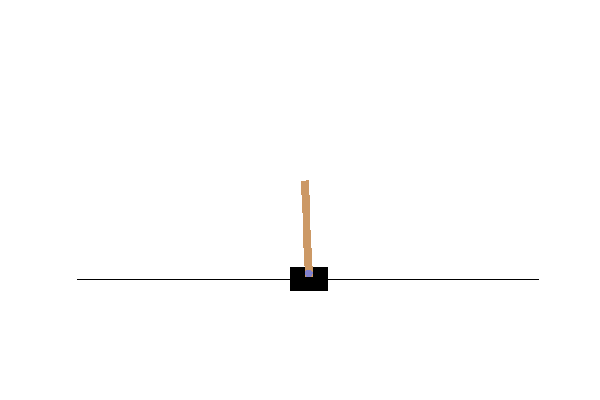
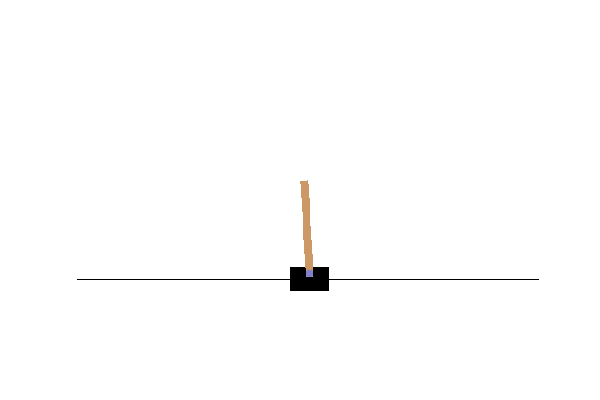
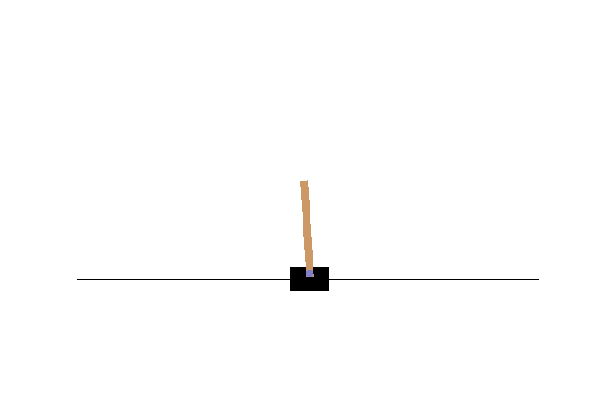
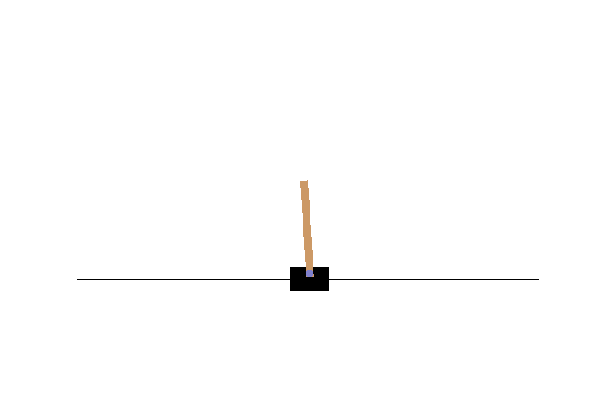
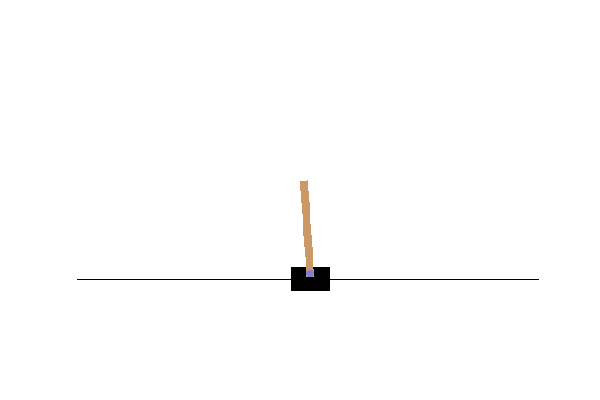
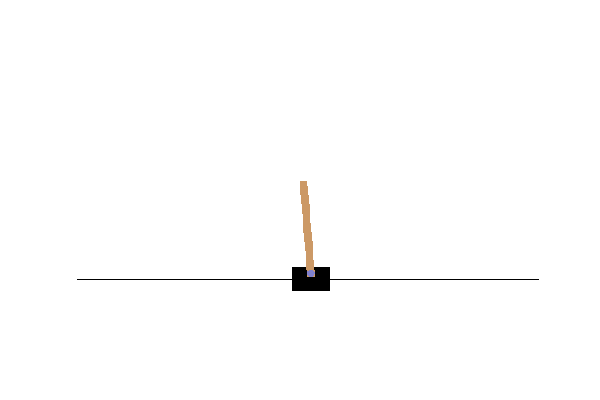
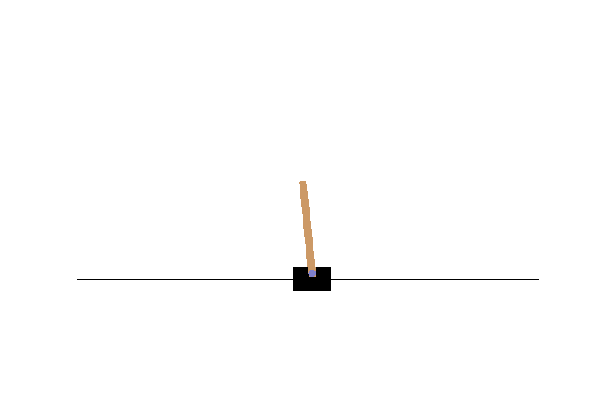
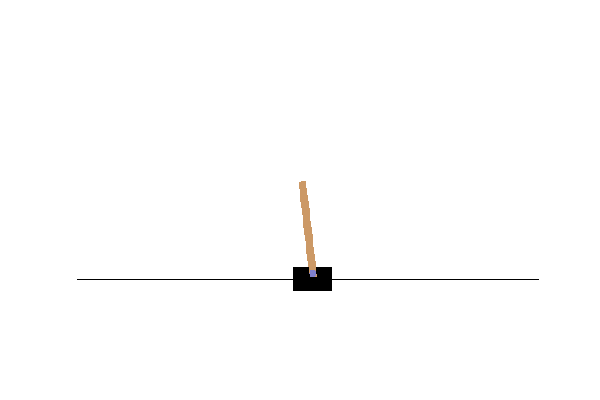
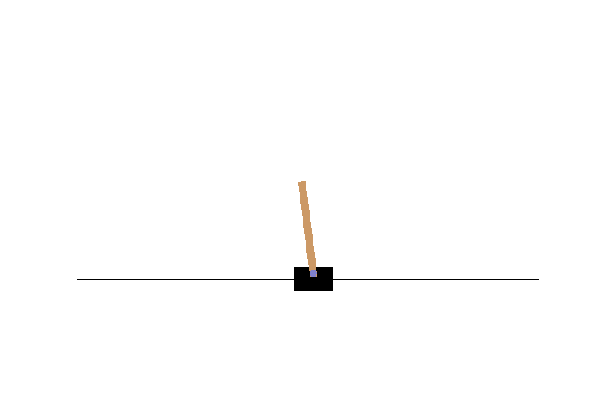
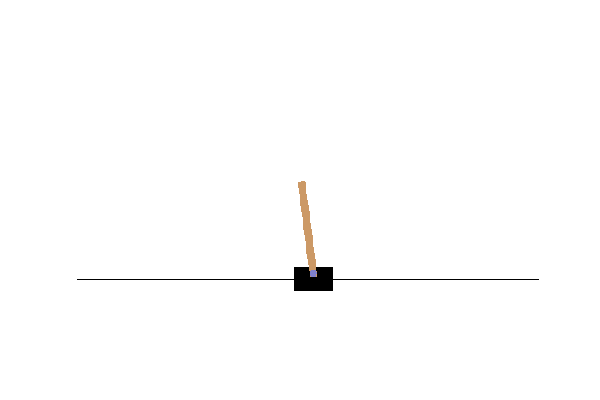
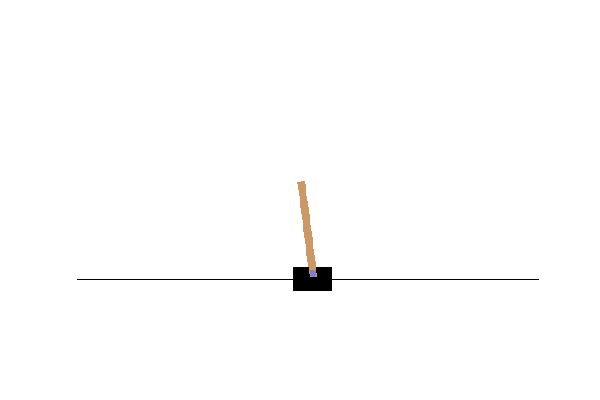
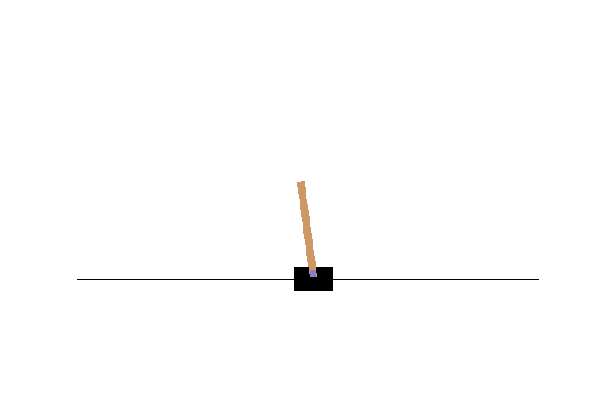
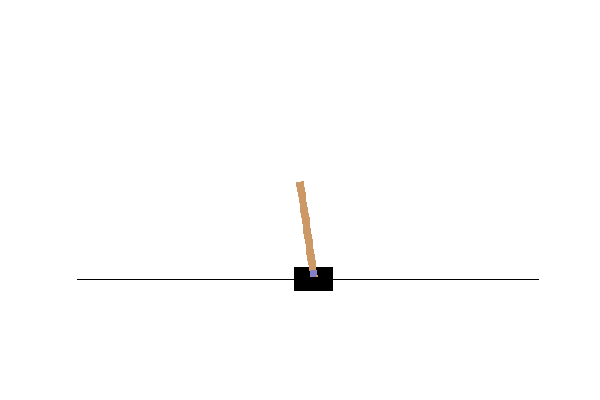
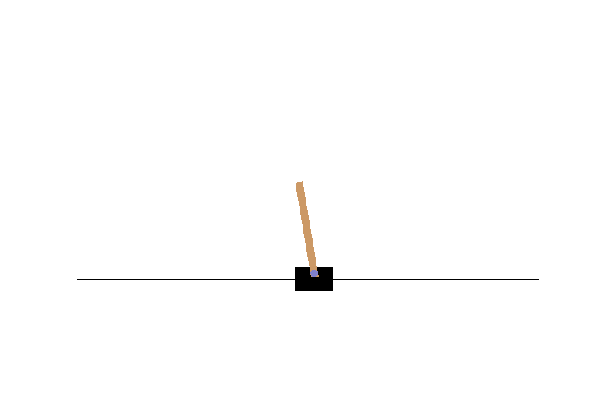
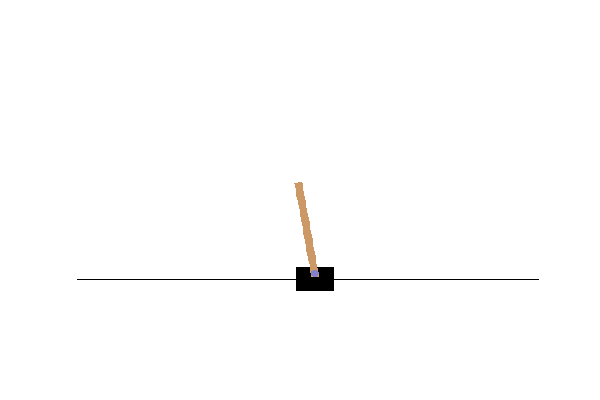
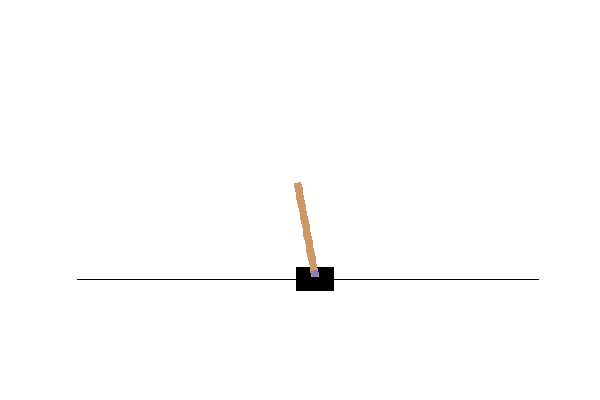
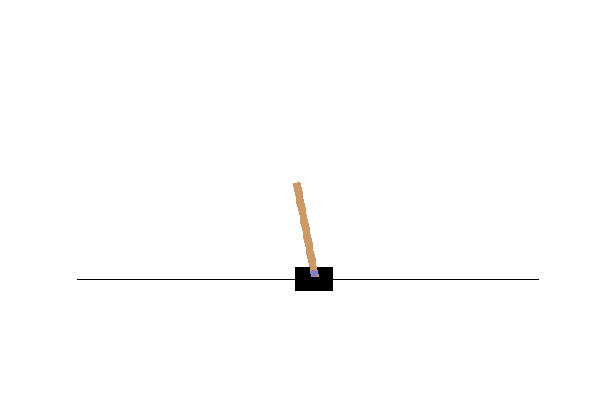
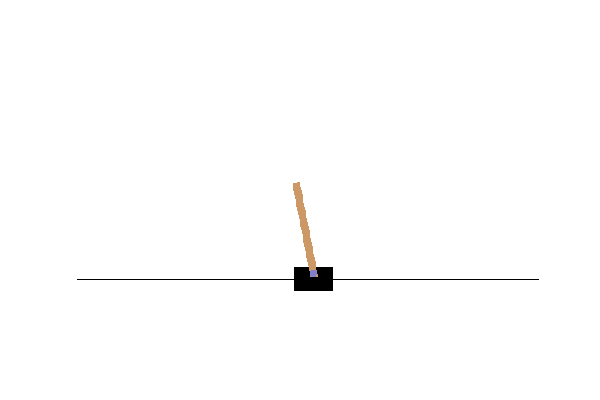
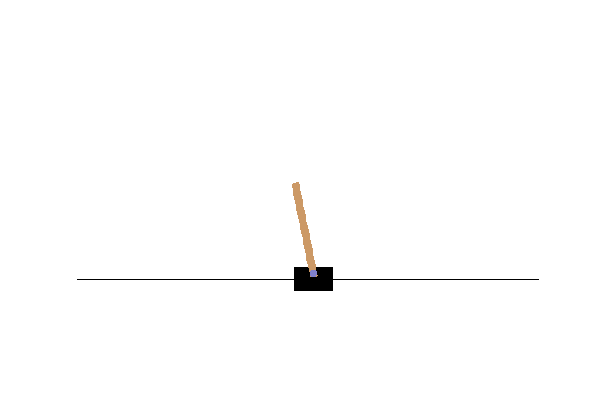
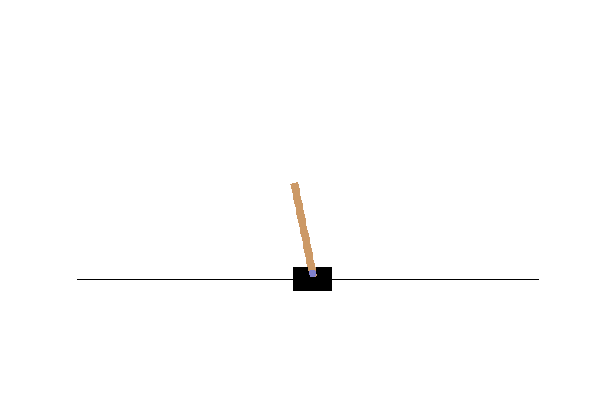
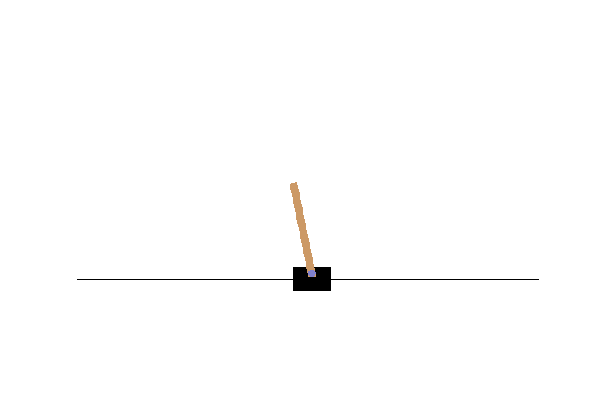
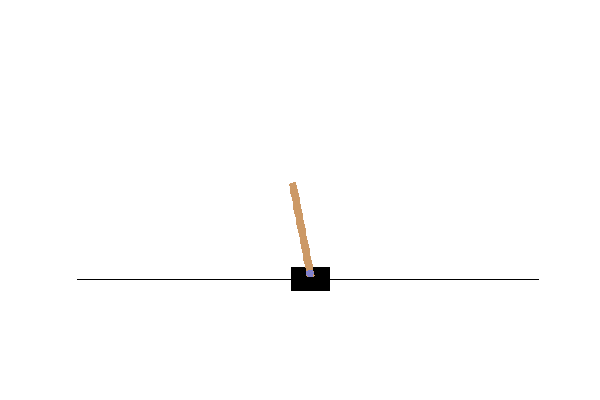
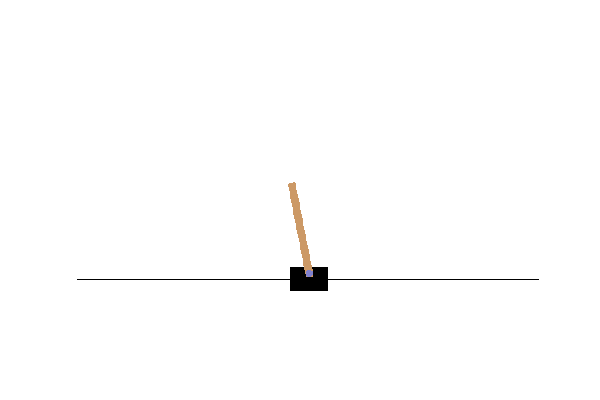
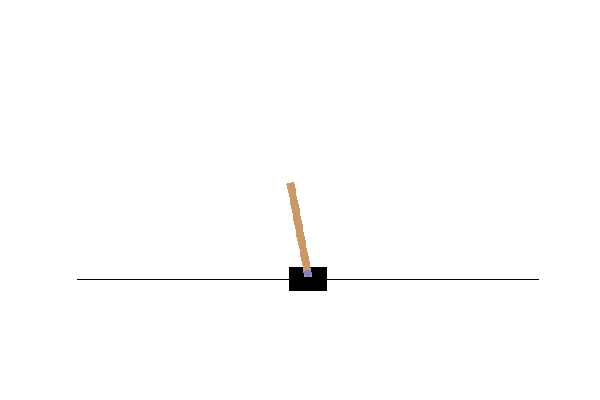
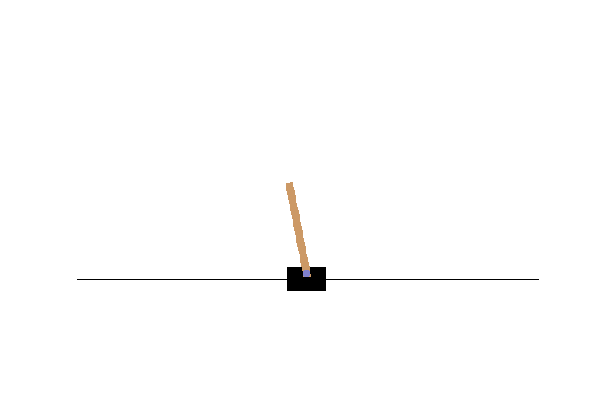
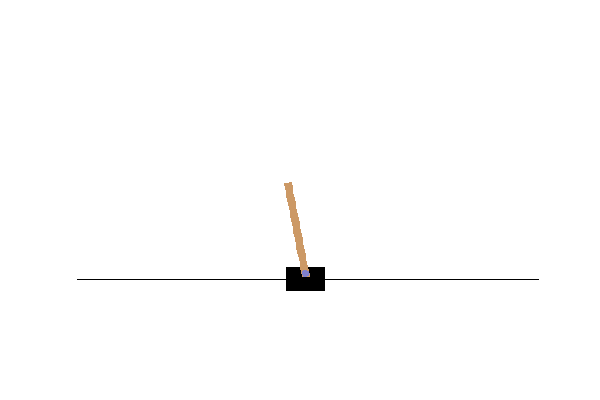
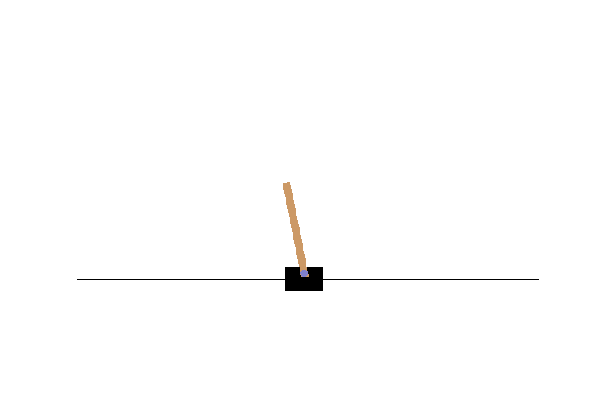
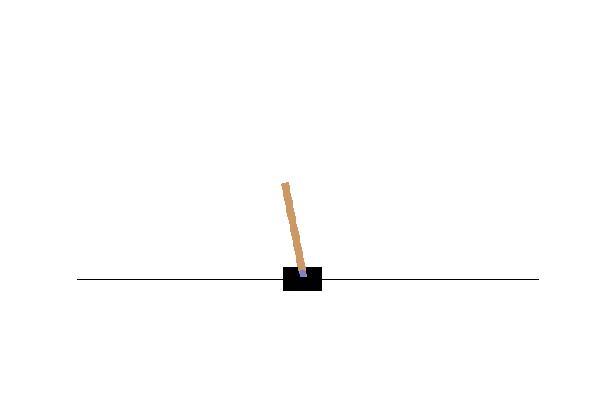
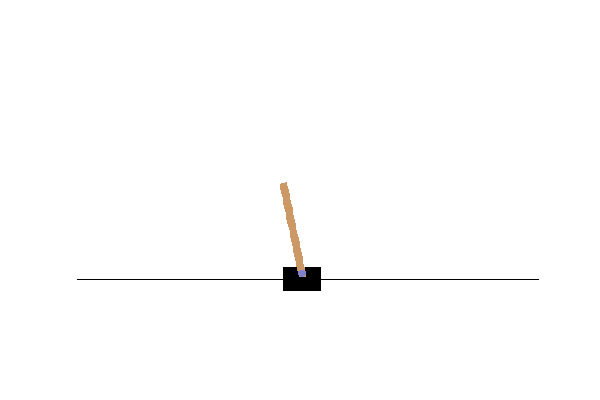
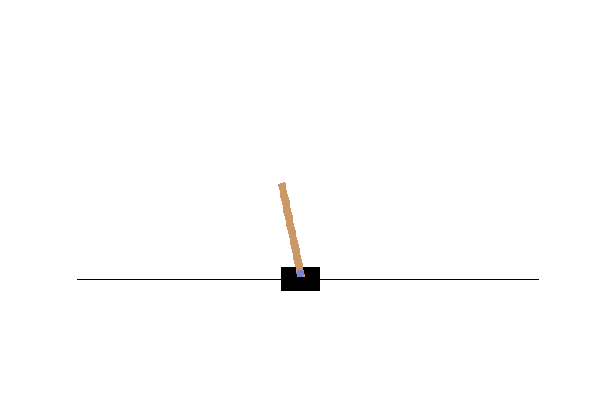
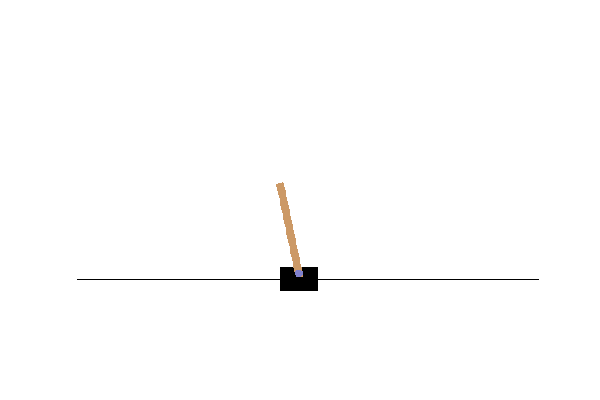
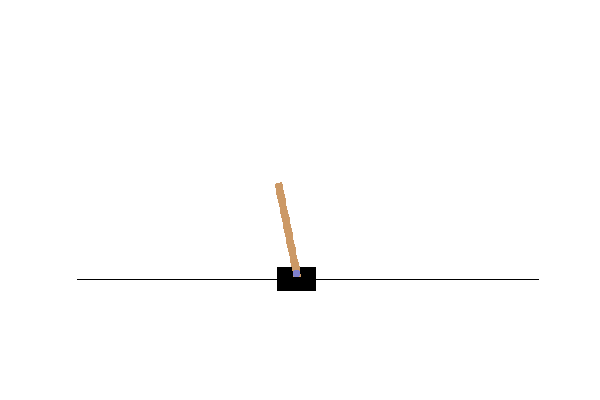
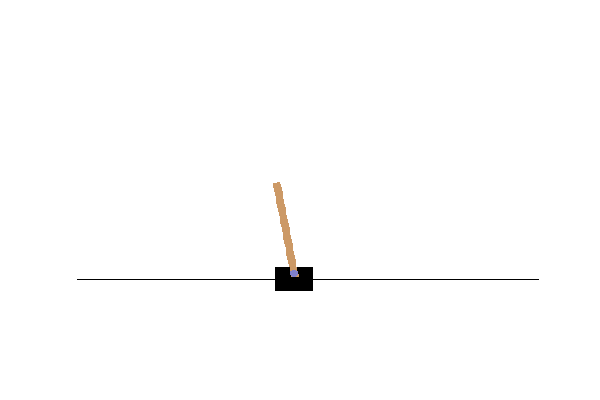
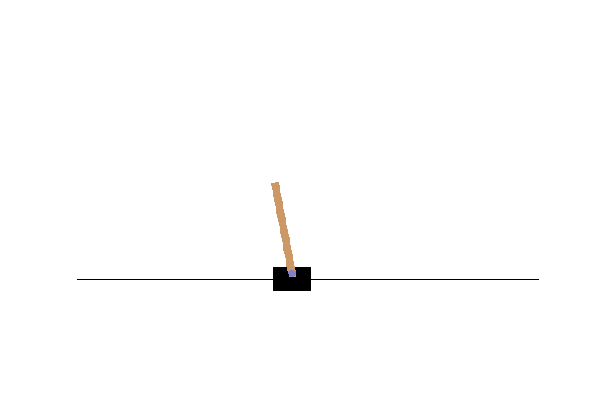
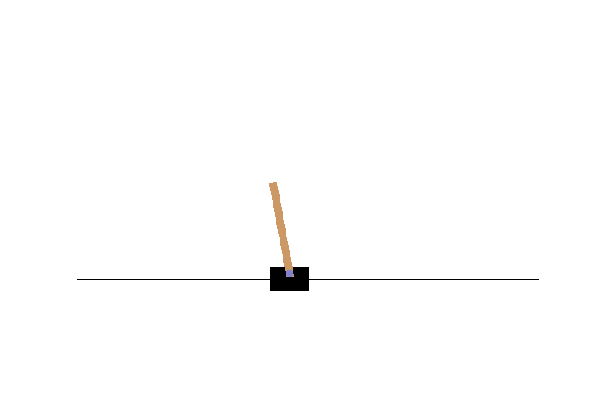
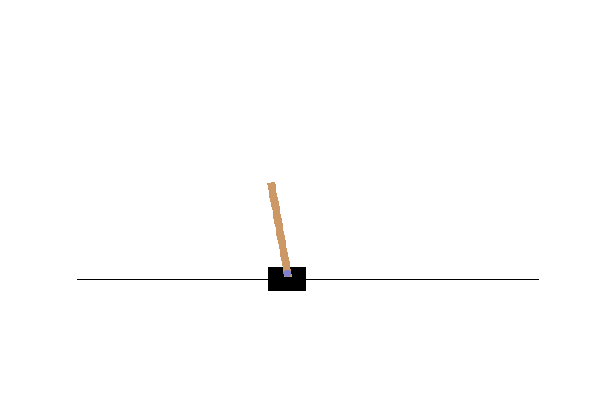
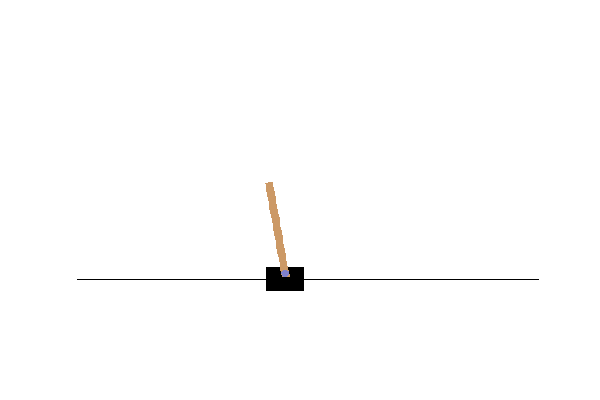
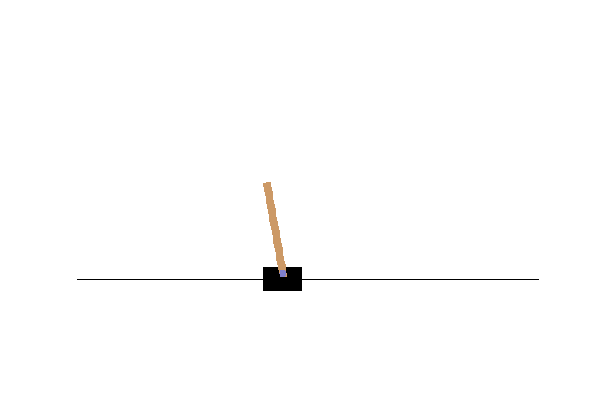
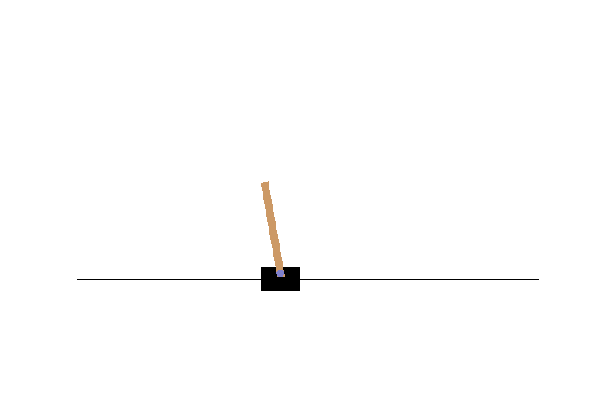
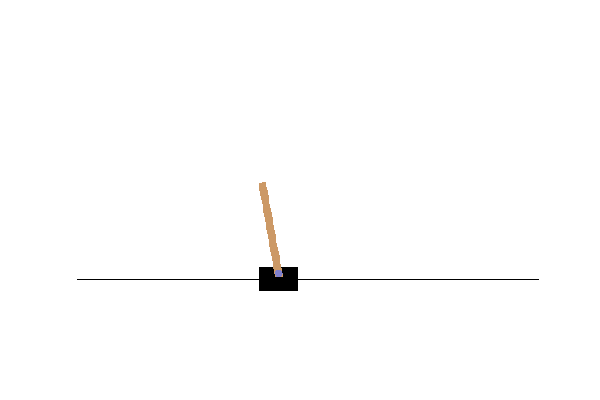
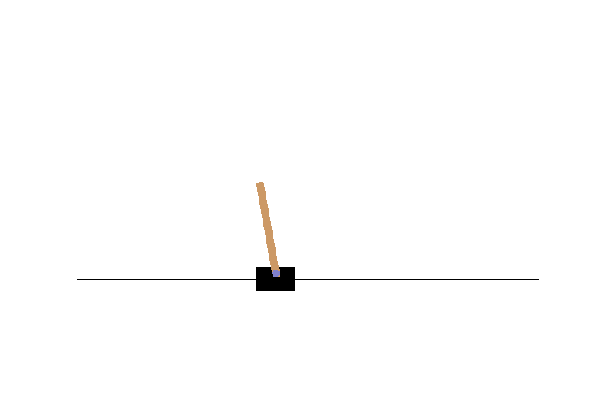
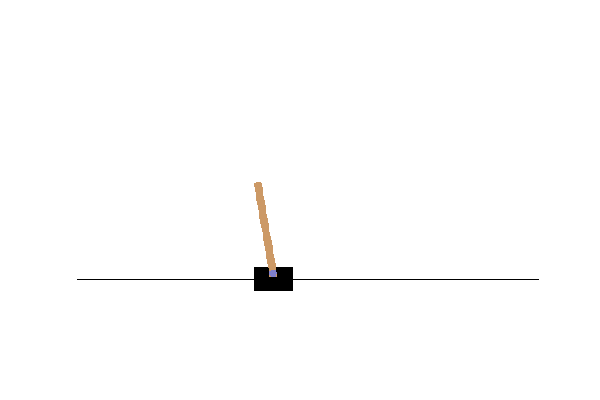
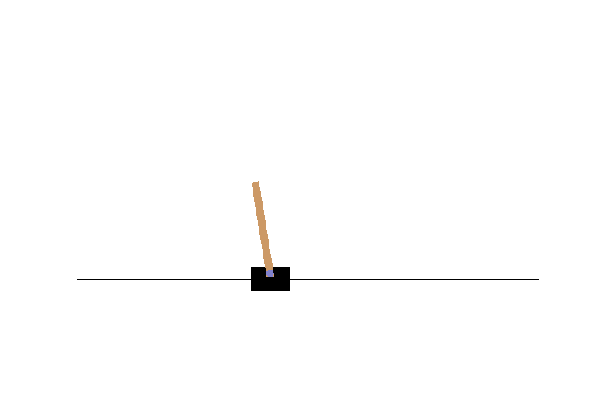
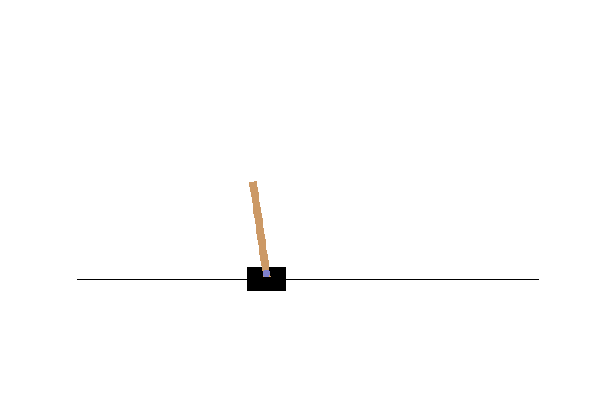
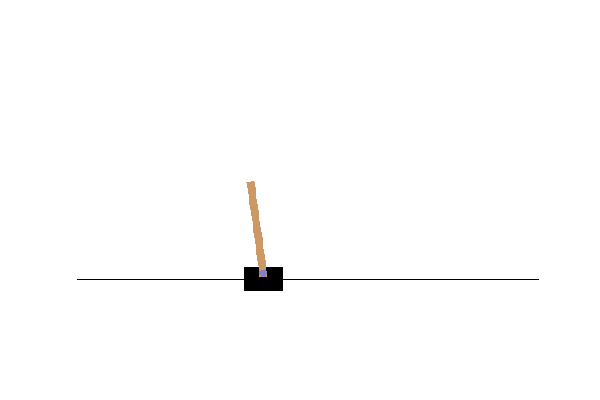
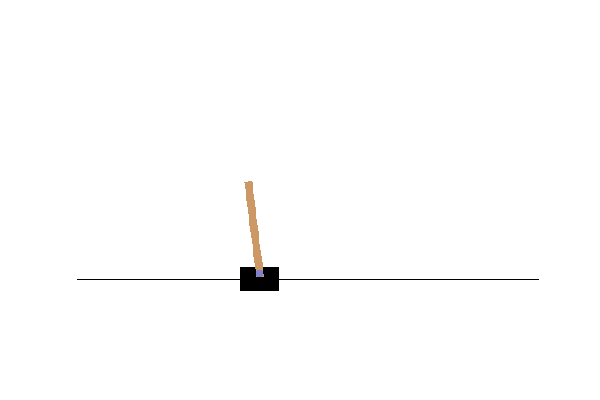
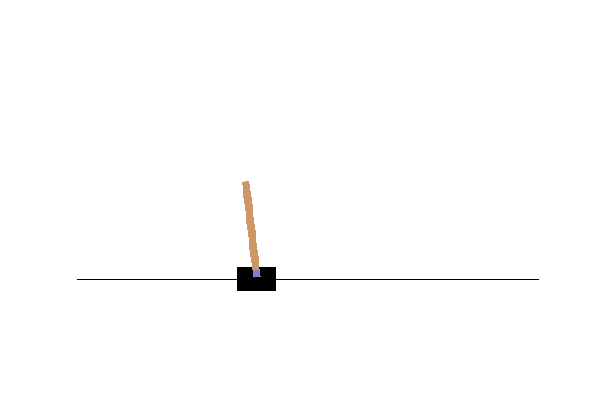
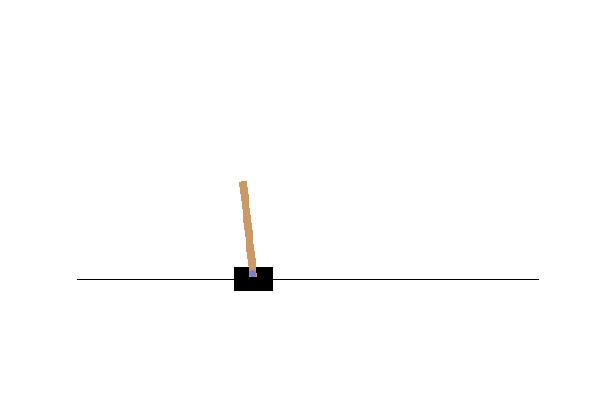
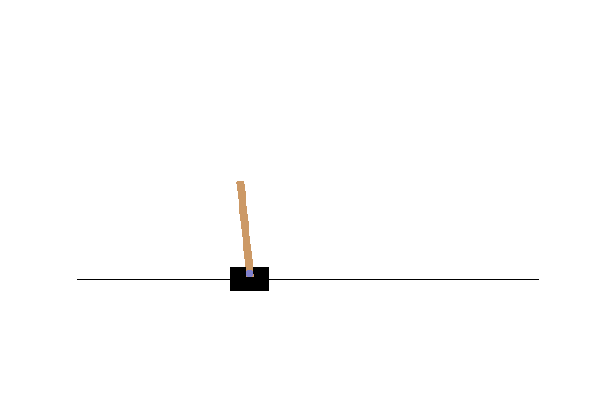
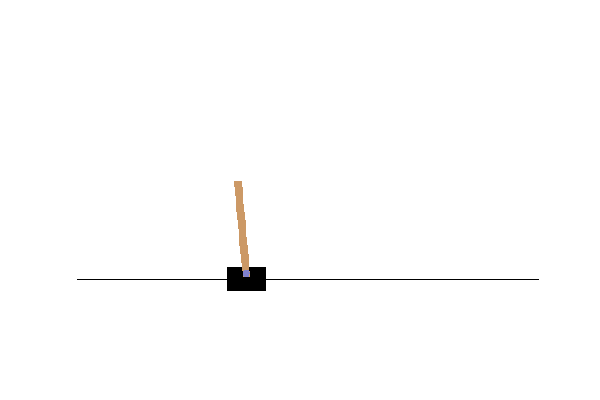
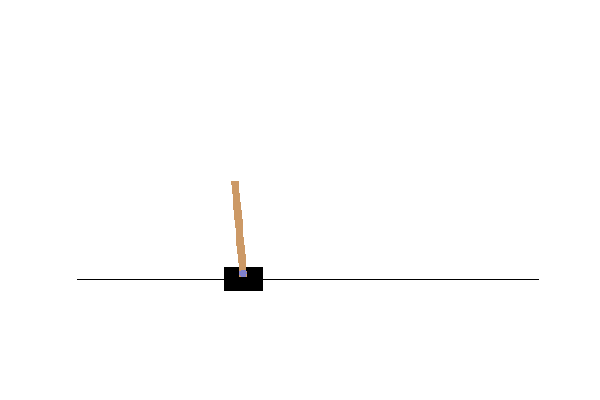
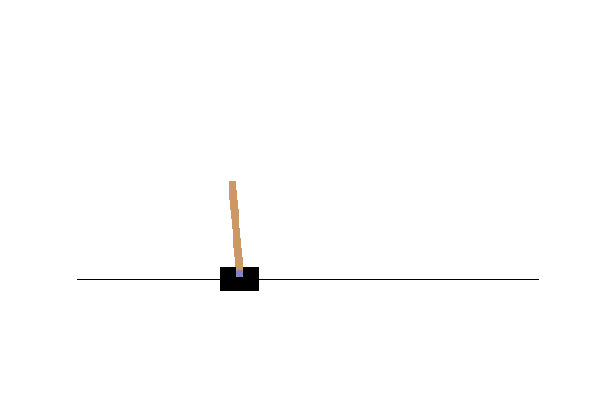
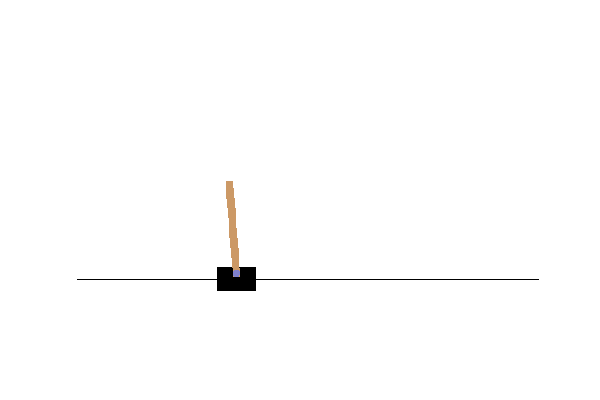
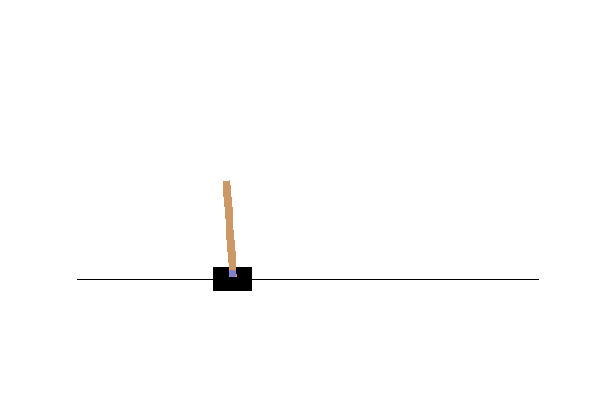
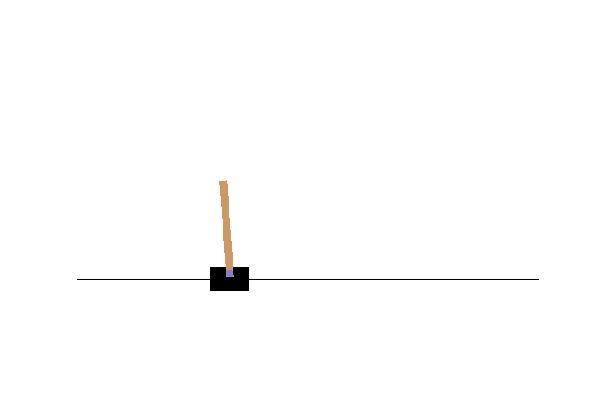
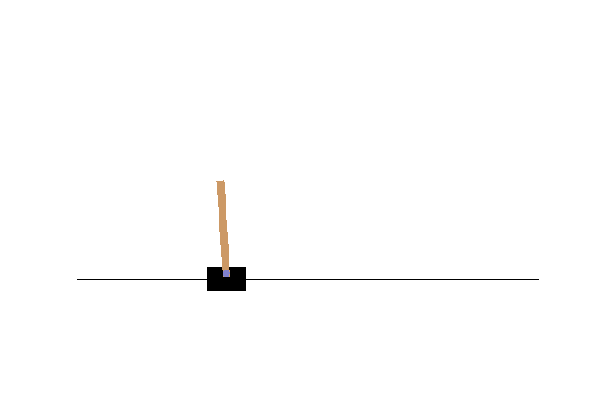
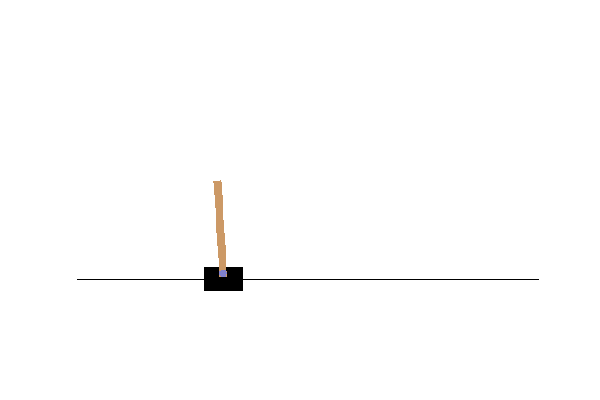
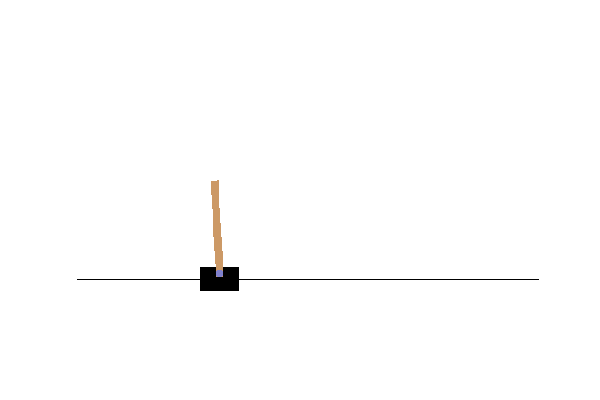
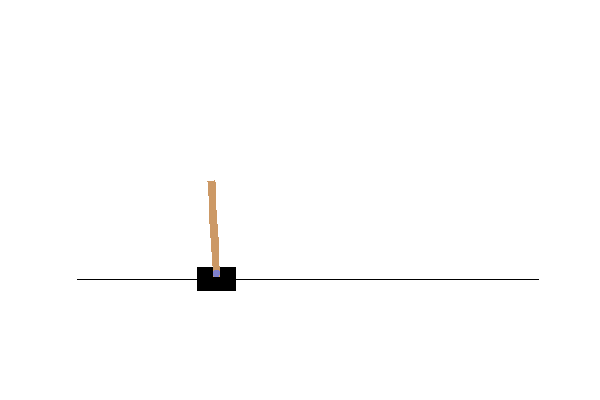
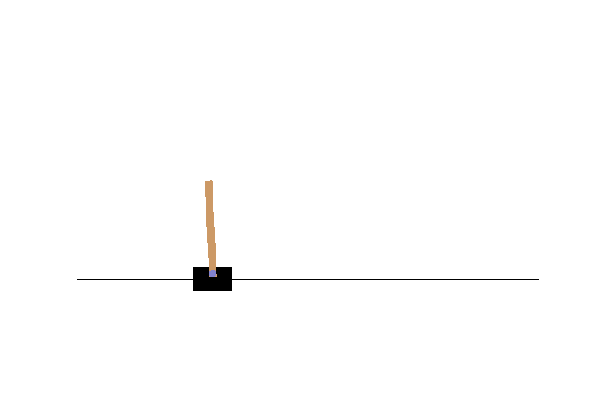
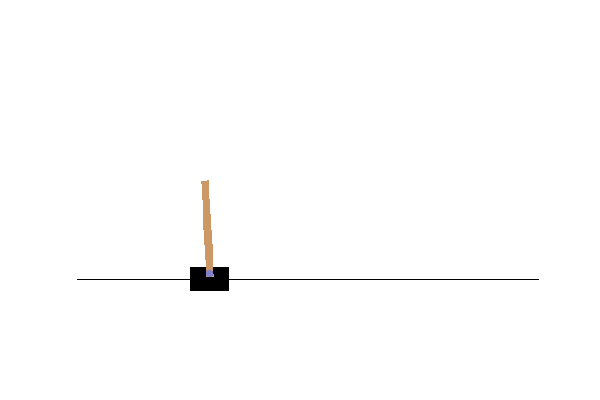
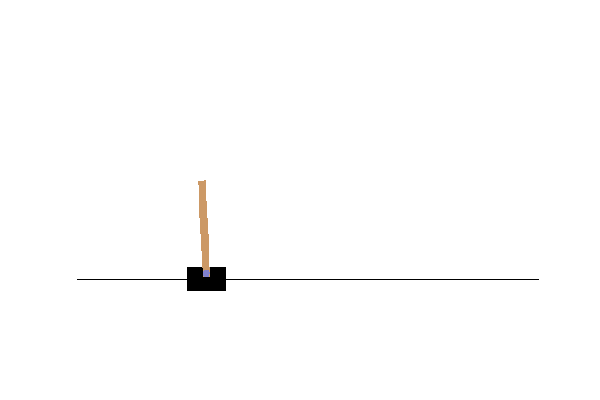
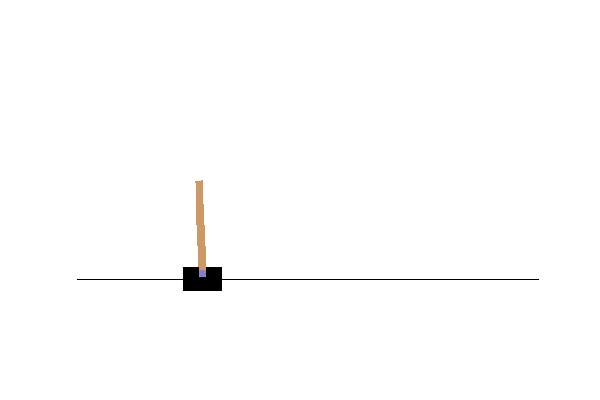
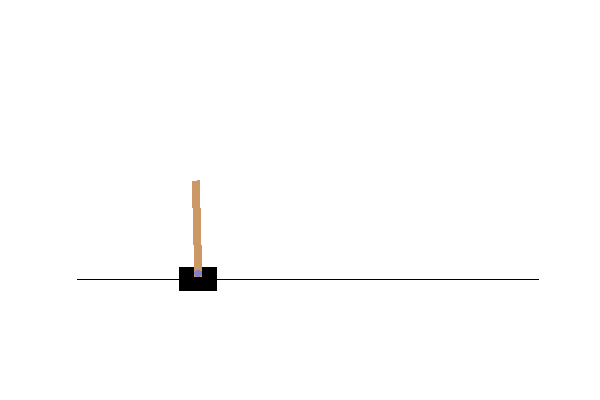
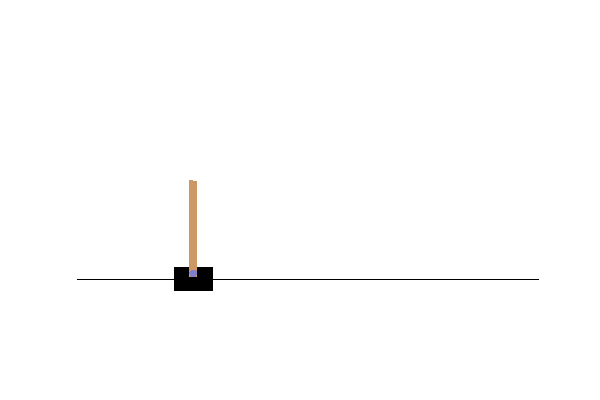
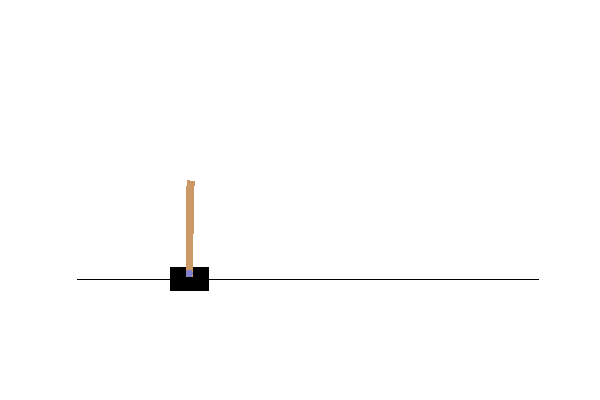
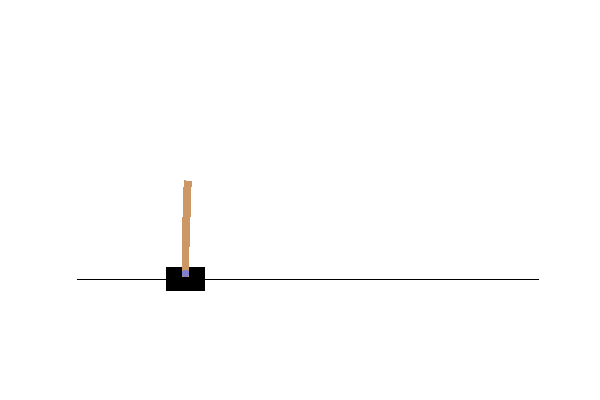
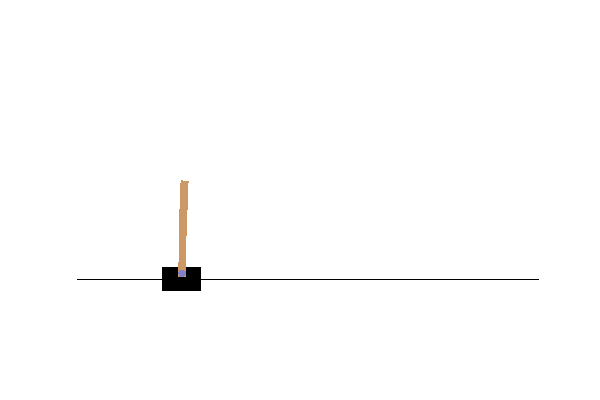
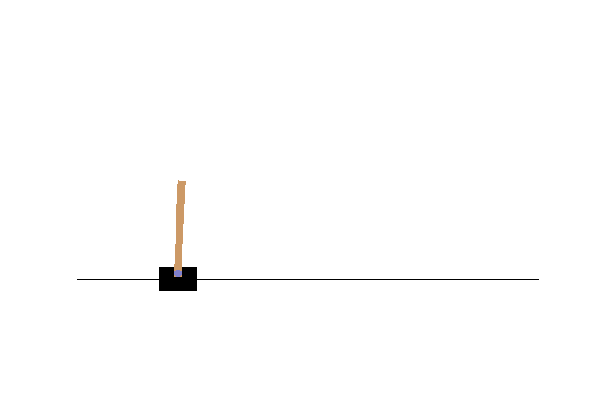
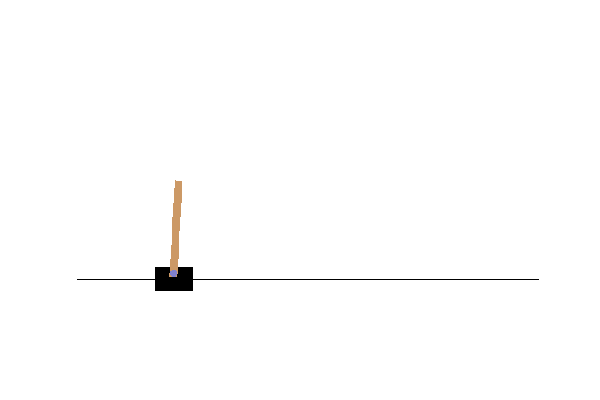
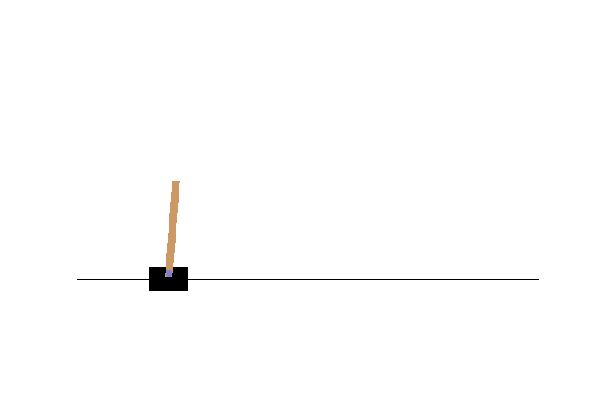
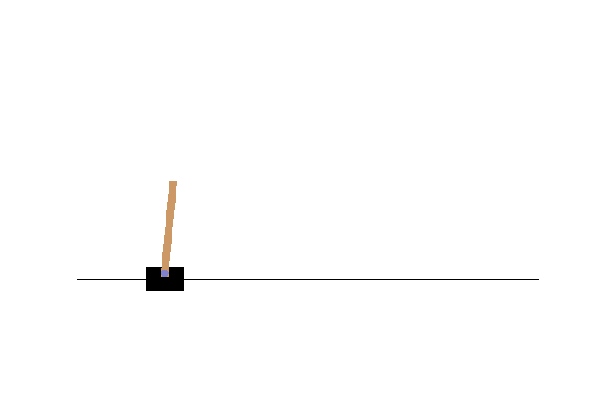
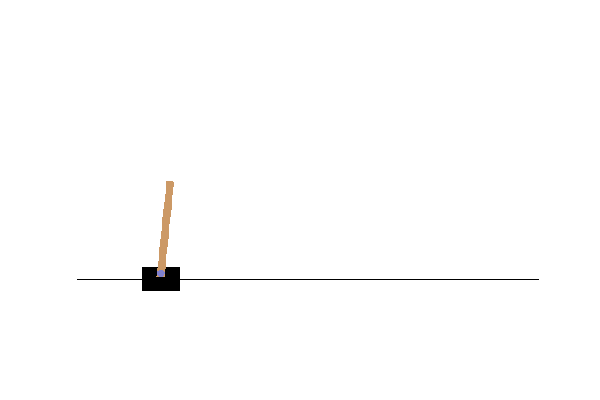
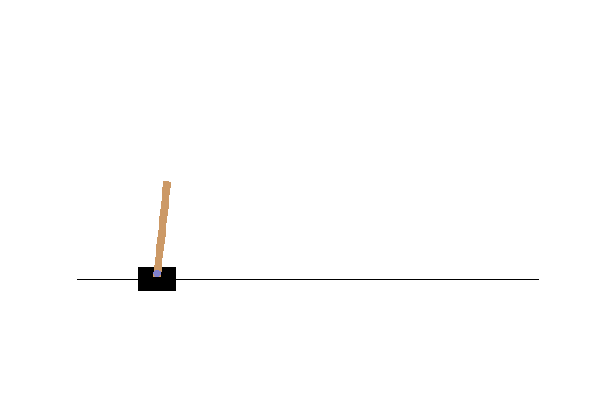
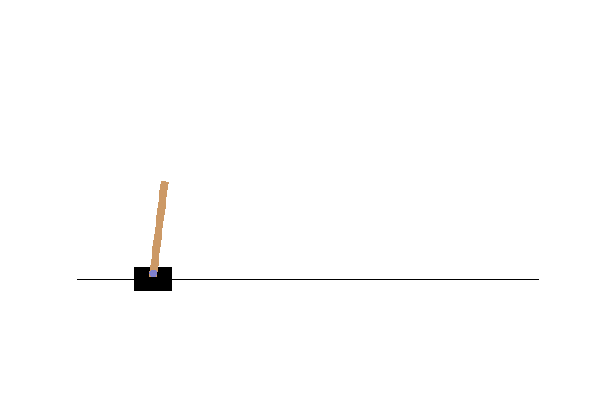
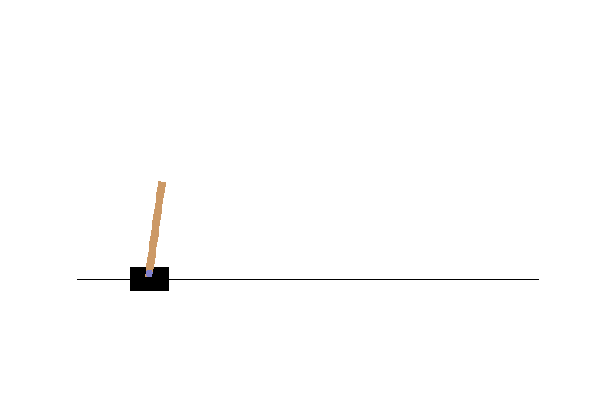
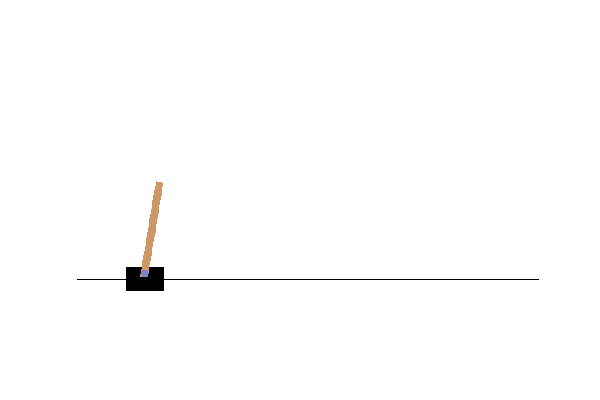

In [12]:
# Now show what we learned: 
drawframes = []
expectedrewards = []
epsilon = 0.01
for _ in range(150):
    newimage = frames_to_nd_image(lastframes)
    expectedreward =  max(max(sess.run(output, feed_dict={inputstate:np.array([newimage], dtype=np.float32)})))
    expectedrewards.append(expectedreward)
    if random.random() <= epsilon:
        newaction = env.action_space.sample() 
    else:    
        actions = sess.run(output, feed_dict={inputstate:np.array([newimage], dtype=np.float32)})
        actions = actions[0]
        newaction = np.argmax(np.array(actions))

    newobservation, rewardhere, done, info = env.step(newaction)
    frame = env.render(mode = 'rgb_array')
    drawframes.append(frame)
    lastframes.append(newobservation)
    lastframes = lastframes[1:]

    newerimage = frames_to_nd_image(lastframes)

    if done:
        observation = env.reset()

display_frames_as_gif(drawframes)

In [ ]:
plt.ioff()
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(expectedrewards)

# w = np.cos(x)
# ax1.plot(x, w) # can continue plotting on the first axis

# plt.plot(np.array(expectedrewards))

In [ ]:
from gym import envs
print(envs.registry.all())
